# Context

Click-through rate (CTR) is a critical metric in digital marketing, representing the effectiveness of online advertisements in driving user engagement. Optimising CTR helps reduce customer acquisition costs and improve campaign ROI. Unlike traditional marketing methods, online campaigns are data-driven and scalable, allowing for advanced targeting strategies. [This dataset](https://www.kaggle.com/datasets/swekerr/click-through-rate-prediction) contains data related to click/no-click recorded for different users. ***In this analysis, I will be answering the following questions:***

---

#### EDA-Based Questions (Exploratory Data Analysis

1. ***How does user demographic information (age, income) relate to CTR?***

2. ***Do time-based behavior (e.g., daily time spent on site, internet usage, timestamp patterns) influence likelihood of clicking on ads?***  

3. ***Are there geographic differences in ad engagement (by city or country)?***  

4. ***Do certain 'Ad Topic Line' perform better in terms of CTR?***  

5. ***What is the relationship between internet use and time on site, and how do those correlate with CTR?***  
---

### Post Model-Training/Counterfactual Questions

6. ***Which user attributes (age, income, location...) are most influential in driving ad clicks, according to the predictive model?***

7. ***Which feature groups are most associated with unpredictable or inaccurate model predictions?***

8. ***Which types of users are most responsive to changes in key factors?***  

9. ***What changes in timing or targeting can boost engagement among the least responsive users?***  

10. ***What hidden trends or unexpected feature combinations did the model uncover that could inform more effective marketing strategies moving forward?***  

---

**NOTE**: This entire analysis is part of my weekly series in efforts to **demystify applied statistical techniques through real-world, project-driven examples**, making concepts like propensity modelling, causal inference, and evaluation metrics more accessible to practitioners of all backgrounds.

Let's connect! --> [LinkedIn](https://www.linkedin.com/in/einstein-ebereonwu/) | [X](https://x.com/einsteinmuna) | [GitHub.](https://github.com/munas-git)

# Importing Important Libraries

In [1]:
# data wrangling
import calendar
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# numerical analysis
import numpy as np
import scipy.stats as stats
from collections import Counter

# data vis
import seaborn as sns
import matplotlib.pyplot as plt

# model training
from sklearn.ensemble import (
    AdaBoostClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, auc, confusion_matrix,
    ConfusionMatrixDisplay, precision_recall_fscore_support, roc_curve)

# hyper-params optimisation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# model explainability
import shap
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay as pdp

# counterfactual
from itertools import product

# handling warnings
import warnings
warnings.filterwarnings('ignore')

print('All done...')

All done...


In [2]:
#hide_input
## Reusable stuff.
print("Completely hidden... reusable code for future.")

def plot_ctr_by_numeric_columns(
        df,
        cols,
        *,
        n_rows: int = 2,
        n_cols: int = 4,
        n_bins: int = 8,
        rolling_window: int = 15,
        figsize: tuple = (30, 8),
        num_colors = None,
        bins_map: dict | None = None,
        smooth_map: dict | None = None,
    ):
    """
    Plots CTR by numeric columns with per-column overrides.

    Parameters
    ----------
    df : pd.DataFrame
        Input data. Must contain a binary column 'Clicked on Ad'.
    cols : list[str]
        Numeric columns to analyse.
    n_rows, n_cols : int
        Layout of the subplot grid (used *as-is*; make sure it can hold 2·len(cols) plots).
    n_bins : int
        Default number of equal-width bins for bar plots.
    rolling_window : int
        Default window size for the smoothed line.
    figsize : tuple[int, int]
        Overall figure size.
    num_colors : list[str] | None
        Optional colour list; defaults to seaborn tab10.
    bins_map : dict[str, int] | None
        Optional per-column bin overrides. Only listed columns are affected.
    smooth_map : dict[str, int] | None
        Optional per-column smoothing-window overrides. Only listed columns are affected.
    """
    if num_colors is None:
        num_colors = sns.color_palette("tab10", len(cols))

    # fall-back to empty dicts so I can always call .get()
    bins_map = bins_map or {}
    smooth_map = smooth_map or {}

    plt.figure(figsize = figsize)

    # ---- smoothed line plots -------------------------------------------------
    for i, col in enumerate(cols, start = 1):
        ax = plt.subplot(n_rows, n_cols, i)
        df_tmp = df.copy()
        df_tmp[col] = df_tmp[col].round(1)

        grouped = (
            df_tmp
            .groupby(col)
            .agg(total_clicks = ('Clicked on Ad', 'sum'),
                 total_ads = ('Clicked on Ad', 'count'))
            .sort_index())

        grouped['ctr'] = grouped['total_clicks'] / grouped['total_ads']
        win = smooth_map.get(col, rolling_window)        # per-column override
        grouped['ctr_smooth'] = (
            grouped['ctr']
            .rolling(window = win, center = True, min_periods = 1)
            .mean())

        sns.lineplot(
            ax = ax,
            x = grouped.index,
            y = grouped['ctr_smooth'],
            marker = 'o',
            color = num_colors[i - 1])

        plt.title(f'CTR by {col} (smoothed, win = {win})', fontsize = 20)
        plt.xlabel(col.title(), fontsize = 20)
        plt.ylabel('CTR', fontsize = 20)
        
        # ax.set(
        #     title=f'CTR by {col} (smoothed, win={win})',
        #     xlabel=col,
        #     ylabel='CTR')

    # ---- equal-width binned bar plots ---------------------------------------
    for i, col in enumerate(cols, start = len(cols) + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        bins = bins_map.get(col, n_bins)                 # per-column override
        bin_labels = [f'B{i}' for i in range(1, bins + 1)]
        df[f'{col}_bin'] = pd.cut(df[col], bins = bins, labels = bin_labels)

        grouped_bin = (
            df
            .groupby(f'{col}_bin')
            .agg(total_clicks = ('Clicked on Ad', 'sum'),
                 total_ads = ('Clicked on Ad', 'count')))
        
        grouped_bin['ctr'] = grouped_bin['total_clicks'] / grouped_bin['total_ads']

        sns.barplot(
            ax = ax,
            x = grouped_bin.index,
            y = grouped_bin['ctr'],
            color = num_colors[i - len(cols) - 1])

        plt.title(f'CTR by {col} (equal-width bins={bins})', fontsize = 20)
        plt.xlabel(f'{col.title()} Bin', fontsize = 20)
        plt.ylabel('CTR', fontsize = 20)
        
        # ax.set(
        #     title=f'CTR by {col} (equal-width bins={bins})',
        #     xlabel=col,
        #     ylabel='CTR')

        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)

    plt.tight_layout()
    plt.show()


def part_of_day(hour):
    if 5 <= hour < 12:
        return 0
    elif 12 <= hour < 17:
        return 1
    elif 17 <= hour < 21:
        return 2
    else:
        return 3


def evaluate_classification_models(X_train, X_test, y_train, y_test, random_state = 32):
    models = {
        'Naive Bayes': GaussianNB(),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'AdaBoost': AdaBoostClassifier(random_state = random_state),
        'Extra Trees': ExtraTreesClassifier(random_state = random_state),
        'SVM (RBF)': SVC(probability = True, random_state = random_state),
        'Random Forest': RandomForestClassifier(random_state = random_state),
        'Decision Tree': DecisionTreeClassifier(random_state = random_state),
        'CatBoost': CatBoostClassifier(verbose = 0, random_state = random_state),
        'Gradient Boosting': GradientBoostingClassifier(random_state = random_state),
        'LightGBM': LGBMClassifier(random_state = random_state, force_col_wise = True),
        'HistGradientBoosting': HistGradientBoostingClassifier(random_state = random_state),
        'Logistic Regression': LogisticRegression(random_state = random_state, max_iter = 1000),
        'XGBoost': XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = random_state)}

    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred)})

    results_df = pd.DataFrame(results)
    return results_df.sort_values(by = 'F1 Score', ascending = False).reset_index(drop = True).T


def decode_value(row, label_encoders, key_column, value_column):
    """
    Decodes an encoded value in `value_column` based on matching the `key_column` value
    to a key in label_encoders dict.
    
    Args:
      row: pd.Series representing a data row.
      label_encoders: dict of {key: LabelEncoder} to decode values.
      key_column: str, column name used to pick encoder key.
      value_column: str, column name of the encoded value to decode.
    
    Returns:
      Decoded value if match found, else original value.
    """
    key_val = row[key_column]
    encoded_val = row[value_column]
    
    for key in label_encoders:
        if key in str(key_val):
            return label_encoders[key].inverse_transform([int(encoded_val)])[0]
    return encoded_val


def generate_counterfactuals(sample_row, model, adjustable_features, possible_values_dict):
    sample = sample_row.copy()
    original_prob = model.predict_proba(sample.values.reshape(1, -1))[:, 1][0]
    
    best_prob = original_prob
    best_changes = sample.copy()
    
    for feature in adjustable_features:
        for val in possible_values_dict[feature]:
            modified = sample.copy()
            modified[feature] = val
            prob = model.predict_proba(modified.values.reshape(1, -1))[:, 1][0]
            if prob > best_prob:
                best_prob = prob
                best_changes = modified.copy()
    
    data = []
    for col in sample.index:
        orig_val = sample[col]
        changed_val = best_changes[col] if best_changes[col] != orig_val else '-'
        data.append({
            'feature_name': col,
            'feature_value': orig_val,
            'adjusted_value': changed_val})
    
    long_df = pd.DataFrame(data)
    return long_df, original_prob, best_prob

Completely hidden... reusable code for future.


In [3]:
df = pd.read_csv('/kaggle/input/click-through-rate-prediction/ad_10000records.csv')

# Some EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked on Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Daily Time Spent on Site,10000.0,61.660757,15.704142,32.60,48.8600,59.59,76.58,90.97
Age,10000.0,35.940100,8.572973,19.00,29.0000,35.00,42.00,60.00
Area Income,10000.0,53840.047721,13343.708718,13996.50,44052.3025,56180.93,61840.26,79332.33
Daily Internet Usage,10000.0,177.759831,40.820951,105.22,140.1500,178.92,212.67,269.96
Clicked on Ad,10000.0,0.491700,0.499956,0.00,0.0000,0.00,1.00,1.00


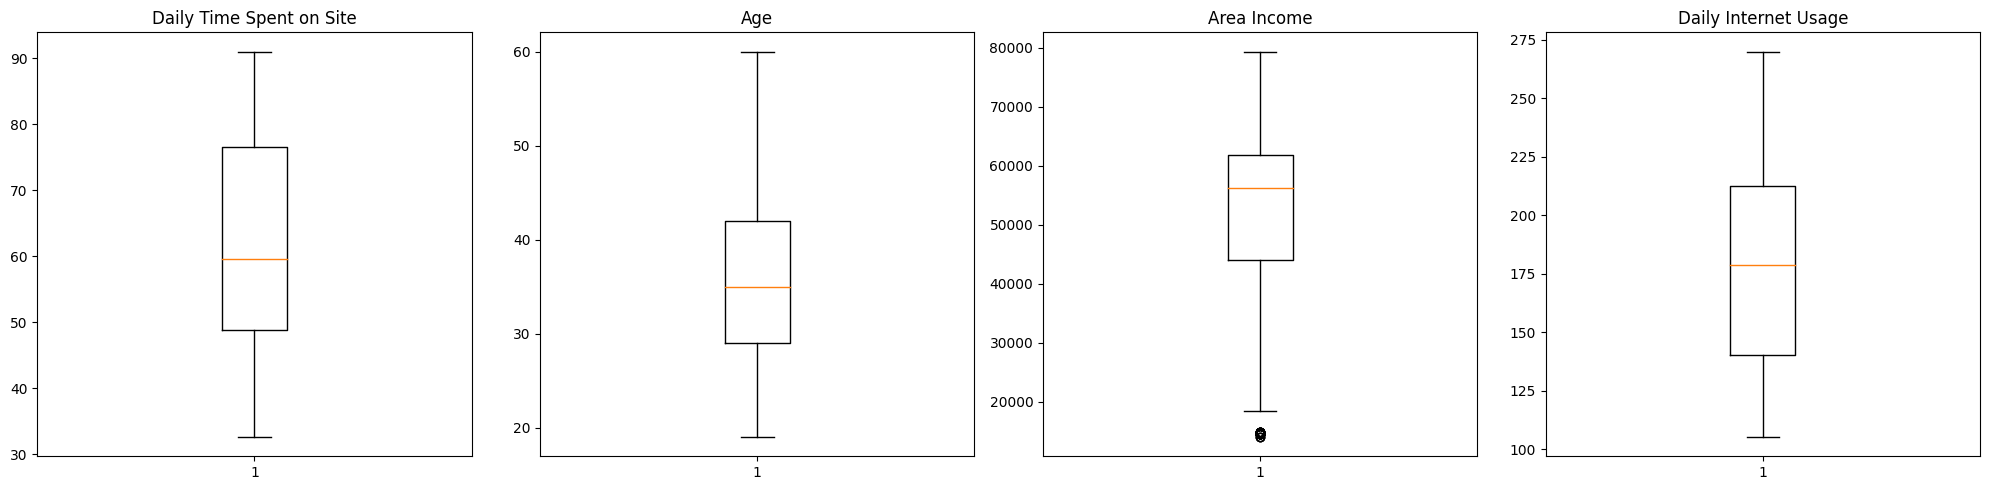

In [6]:
numerical_cols = df.select_dtypes(include = 'number').columns[:-1]

fig, axes = plt.subplots(1, len(numerical_cols), figsize = (20, 5))
for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

**Observation**   

The dataset is quite nice and clean... Only a few potential outliers observed under the area income. I will leave them in for now however, if they skew model predictions, I will take them out.

In [7]:
# extracting time-based temporal features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['hour'] = df['Timestamp'].dt.hour
df['day'] = df['Timestamp'].dt.day
df['weekday'] = df['Timestamp'].dt.weekday
df['month'] = df['Timestamp'].dt.month


# category encodings
label_encoders = {}
for col in df.select_dtypes(include = 'object'):
    df[col] = df[col].str.title().str.strip()

    le = LabelEncoder()
    df[col + '_label'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [8]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,hour,day,weekday,month,Ad Topic Line_label,City_label,Gender_label,Country_label
0,62.26,32.0,69481.85,172.83,Decentralized Real-Time Circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,21,9,3,6,96,234,1,174
1,41.73,31.0,61840.26,207.17,Optional Full-Range Projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0,17,16,5,1,301,460,1,166
2,44.40,30.0,57877.15,172.83,Total 5Thgeneration Standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0,10,29,2,6,484,379,0,71
3,59.88,28.0,56180.93,207.17,Balanced Empowering Success,New Michael,Female,Zambia,2016-06-21 14:32:32,0,14,21,1,6,24,269,0,205
4,49.21,30.0,54324.73,201.58,Total 5Thgeneration Standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1,10,21,3,7,484,495,0,149


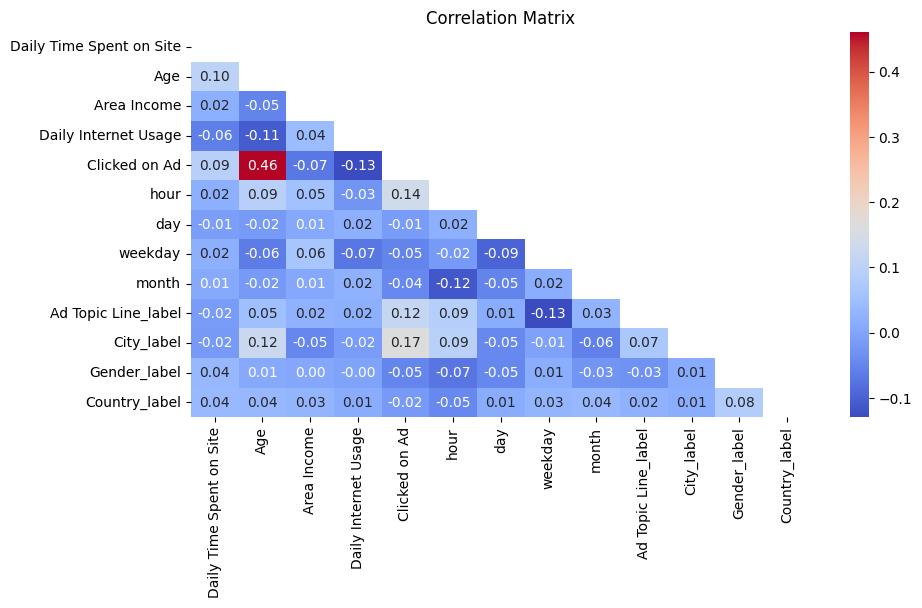

In [9]:
# multicollinearity check
correlation_matrix = df[df.select_dtypes(include = 'number').columns].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize = (10, 5))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', mask = mask)
plt.title('Correlation Matrix')
plt.show()

# will be useful while I'm assess the reliability of my non tree-based models PartialDependence plots

**Observation**   

`Age` is the only variable with a questionable correlation with clicking on add... I will investigate further, and if my trained models seem to be overfitting on training and/or test data, age will be the first column to be engineered/dropped during the next round of feature selection.

## Age & Income Impact Analysis

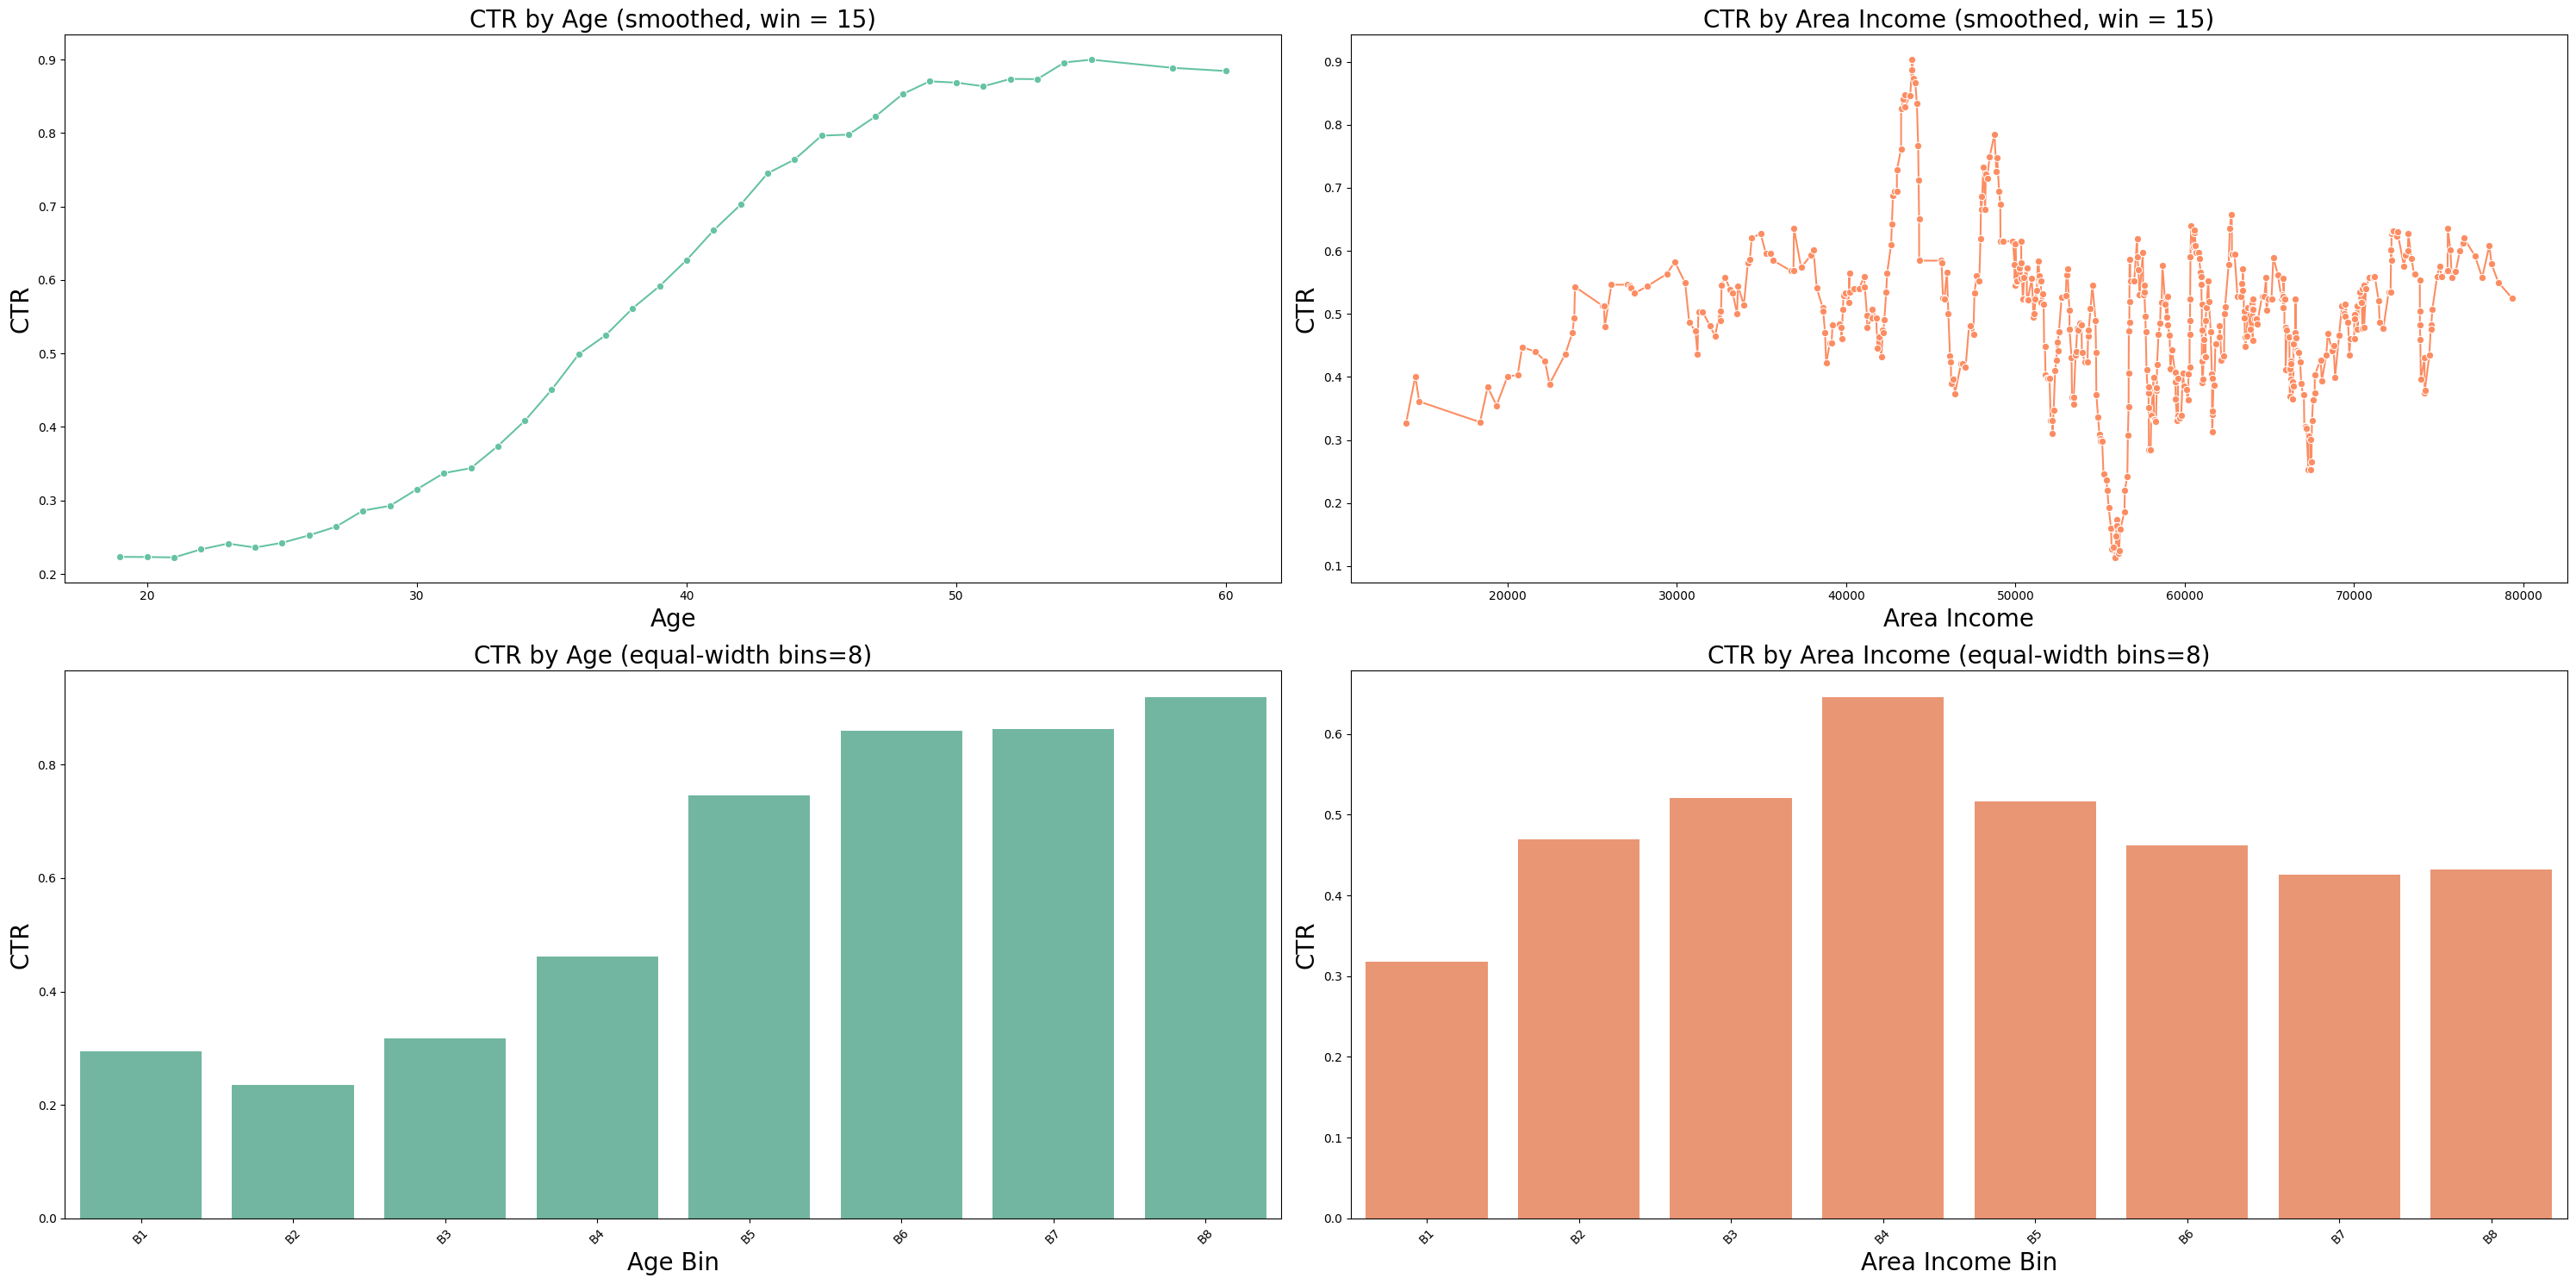

In [10]:
plot_ctr_by_numeric_columns(
    df = df,
    cols = ['Age', 'Area Income'],
    n_rows = 2,
    n_cols = 2,
    n_bins = 8,
    figsize = (30, 15),
    rolling_window = 15,
    num_colors = sns.color_palette("Set2", 8))

**Observation**   

CTR increases significantly with **age**, rising from low levels in younger users to a peak among those in their **50s and 60s**.  
In contrast, the relationship with **area income** is non-linear, with CTR peaking at **middle-income levels** (~40K) and declining at higher incomes.


> Might be interesting to see the relationship between age and area income.... For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

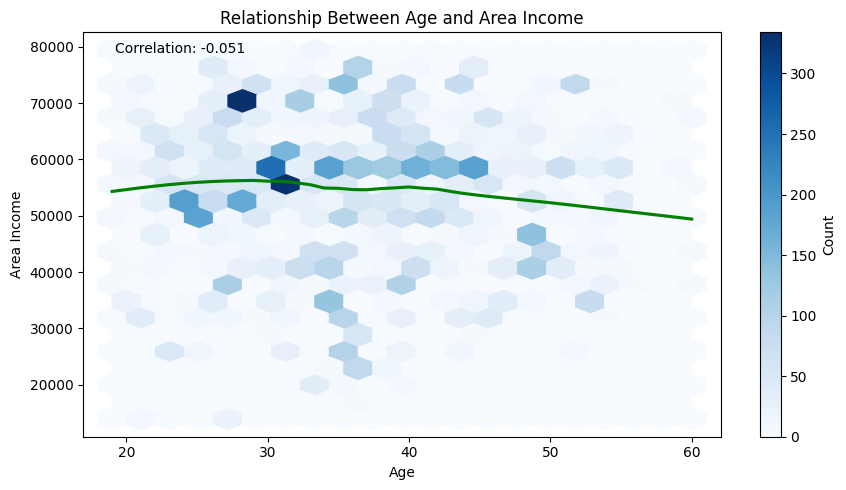

In [11]:
plt.figure(figsize = (9, 5))

plt.hexbin(df['Age'], df['Area Income'], gridsize = 20, cmap = 'Blues')
plt.colorbar(label = 'Count')

sns.regplot(data = df, x = 'Age', y = 'Area Income', scatter = False, 
            lowess = True, line_kws = {'color': 'green'})

plt.title('Relationship Between Age and Area Income')
plt.xlabel('Age')
plt.ylabel('Area Income')

correlation = df['Age'].corr(df['Area Income'])
plt.annotate(f'Correlation: {correlation:.3f}', 
             xy = (0.05, 0.95), xycoords = 'axes fraction')

plt.tight_layout()
plt.show()

**Observation**   

Well.... The relationship is `definitely not linear`. Age and individual income might have shown a different trend.

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

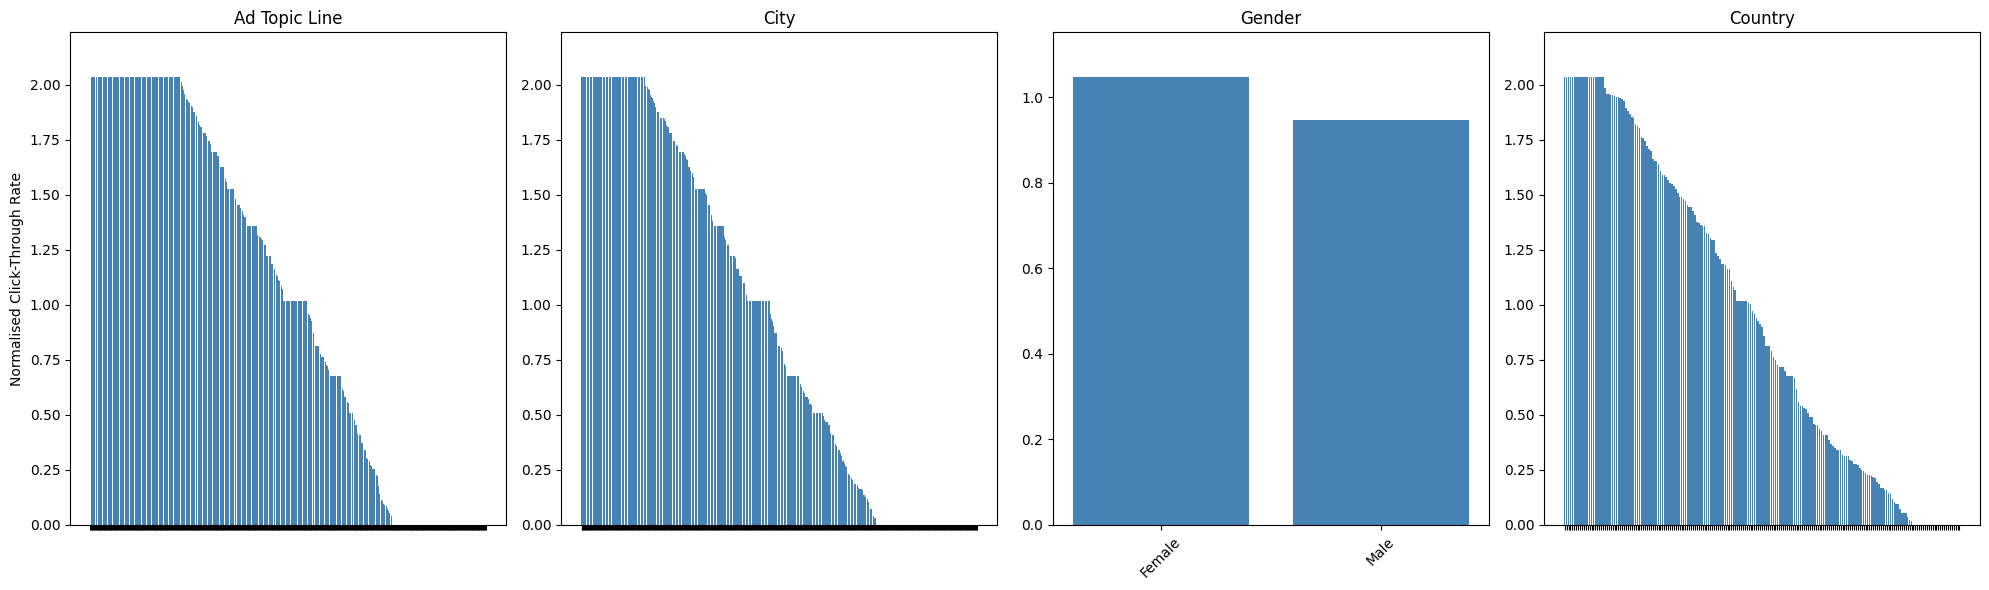

In [12]:
categorical_cols = df.select_dtypes(include ='object').columns.tolist()

# Calculate overall CTR for the entire dataset
total_clicks = df['Clicked on Ad'].sum()
total_impressions = len(df)
overall_ctr = total_clicks / total_impressions

plt.figure(figsize = (20, 6))

for i, col in enumerate(categorical_cols, start=1):
    clicks_by_col = df.groupby(col)['Clicked on Ad'].sum()
    ads_sent_by_col = df.groupby(col)['Clicked on Ad'].count()
    
    # CTR for each category
    ctr_by_col = clicks_by_col / ads_sent_by_col    
    normalised_ctr_by_col = ctr_by_col / overall_ctr
    normalised_ctr_by_col = normalised_ctr_by_col.sort_values(ascending = False)
    
    plt.subplot(1, len(categorical_cols), i)
    bars = plt.bar(range(len(normalised_ctr_by_col)), normalised_ctr_by_col.values, color = 'steelblue')
    
    plt.title(f'{col}', fontsize = 12)
    plt.ylim(0, normalised_ctr_by_col.max() * 1.1)
    
    if col == 'Gender':
        plt.xticks(range(len(normalised_ctr_by_col)), normalised_ctr_by_col.index, rotation=45)
    else:
        plt.xticks(range(len(normalised_ctr_by_col)), [' '] * len(normalised_ctr_by_col))
    
    if i == 1:
        plt.ylabel('Normalised Click-Through Rate')

plt.tight_layout()
plt.show()

**Observation**   

From the plots above, it looks like certain `ad topic lines, cities`, and `coutries` are associated with higher click-through-rates, and as for Gender, `Females` account for a majority of the click-through-rates. All plots above have been normalised to avoid the ***base rate fallacy.***

**Let's find out the top/bottom 10 performing Topic lines, Cities, and Countries.**

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

## Topic & Location Impact Analysis


Top cities in the top countries:


,City,Country



Bottom cities in the bottom countries:


,City,Country


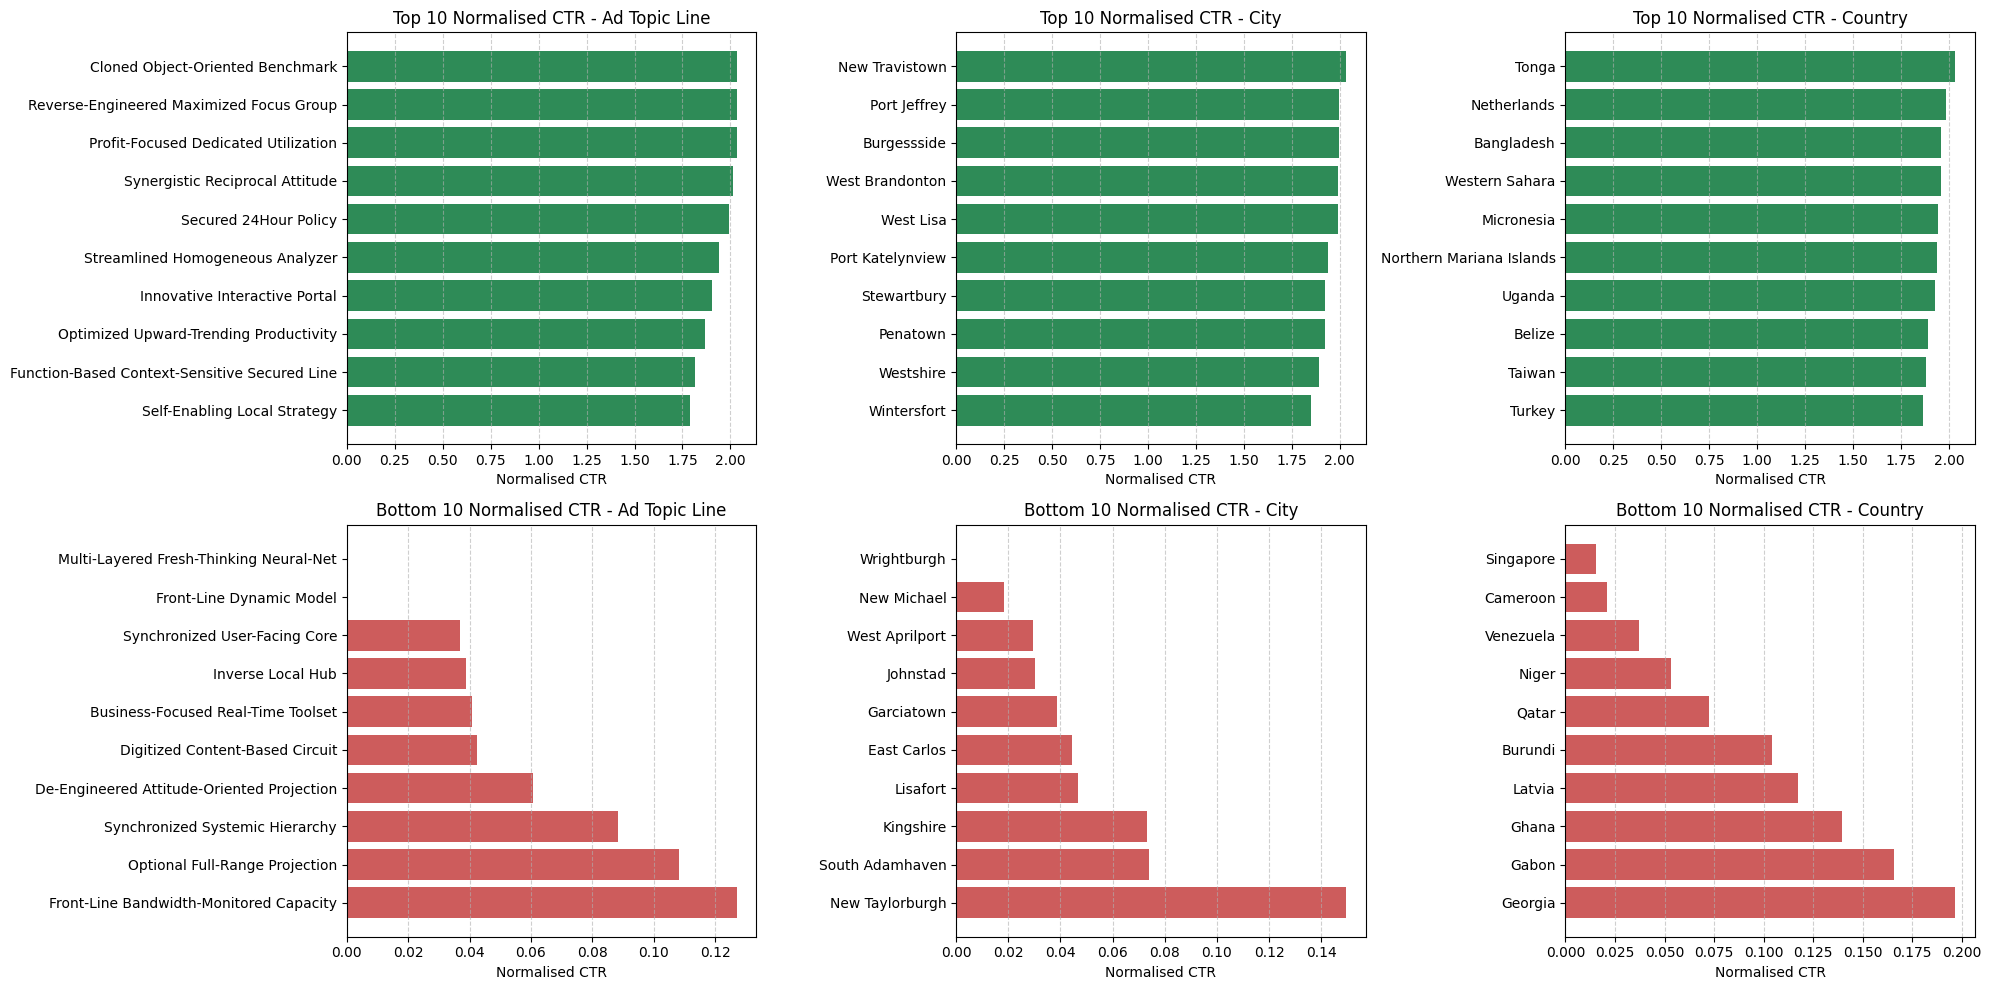

In [13]:
min_volume = 50
categorical_cols = ['Ad Topic Line', 'City', 'Country']

# overall CTR for the entire dataset
plt.figure(figsize = (20, 10))
for i, col in enumerate(categorical_cols):
    # Group by category and calculate CTR
    grouped = df.groupby(col)['Clicked on Ad']
    clicks = grouped.sum()
    impressions = grouped.count()
    ctr = clicks / impressions

    # normalise CTR by overall CTR
    normalised_ctr = ctr / overall_ctr  

    # filtering out low-volume categories
    valid = impressions[impressions >= min_volume].index
    normalised_ctr = normalised_ctr.loc[valid]
    impressions = impressions.loc[valid]

    # top 10 and bottom 10
    top_10 = normalised_ctr.sort_values(ascending = False).head(10)
    bottom_10 = normalised_ctr.sort_values().head(10)

    plt.subplot(2, len(categorical_cols), i + 1)
    plt.barh(top_10.index[::-1], top_10.values[::-1], color = 'seagreen')
    plt.title(f'Top 10 Normalised CTR - {col}')
    plt.xlabel('Normalised CTR')
    plt.grid(axis = 'x', linestyle = '--', alpha = 0.6)

    plt.subplot(2, len(categorical_cols), i + 1 + len(categorical_cols))
    plt.barh(bottom_10.index[::-1], bottom_10.values[::-1], color = 'indianred')
    plt.title(f'Bottom 10 Normalised CTR - {col}')
    plt.xlabel('Normalised CTR')
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    # top/bottom cities in relation to their country
    if col == 'City':
        top_cities = top_10.index
        bottom_cities = bottom_10.index

        # Corresponding countries for top and bottom cities
        top_cities_countries = df[df['City'].isin(top_cities)][['City', 'Country']].drop_duplicates()
        bottom_cities_countries = df[df['City'].isin(bottom_cities)][['City', 'Country']].drop_duplicates()

        # Top countries from the 'Country' column
        top_countries = normalised_ctr.sort_values(ascending = False).head(10).index
        bottom_countries = normalised_ctr.sort_values().head(10).index

        # Are top cities from the top countries?
        top_cities_from_top_countries = top_cities_countries[top_cities_countries['Country'].isin(top_countries)]
        bottom_cities_from_bottom_countries = bottom_cities_countries[bottom_cities_countries['Country'].isin(bottom_countries)]

        print(f"\nTop cities in the top countries:")
        display(top_cities_from_top_countries)
        print(f"\nBottom cities in the bottom countries:")
        display(bottom_cities_from_bottom_countries)

plt.tight_layout()
plt.show()

**Observation**   

Surprisingly enough, none of the top cities are from the top countries, and none of the bottom cities are from the bottom countries.

> Disclaimer :) This unfortunately is toy data... In reality, I expect that at least 1 of the top/lowest cities might fall within the top/bottom countries respectively. For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

## Time Based Impact Analysis

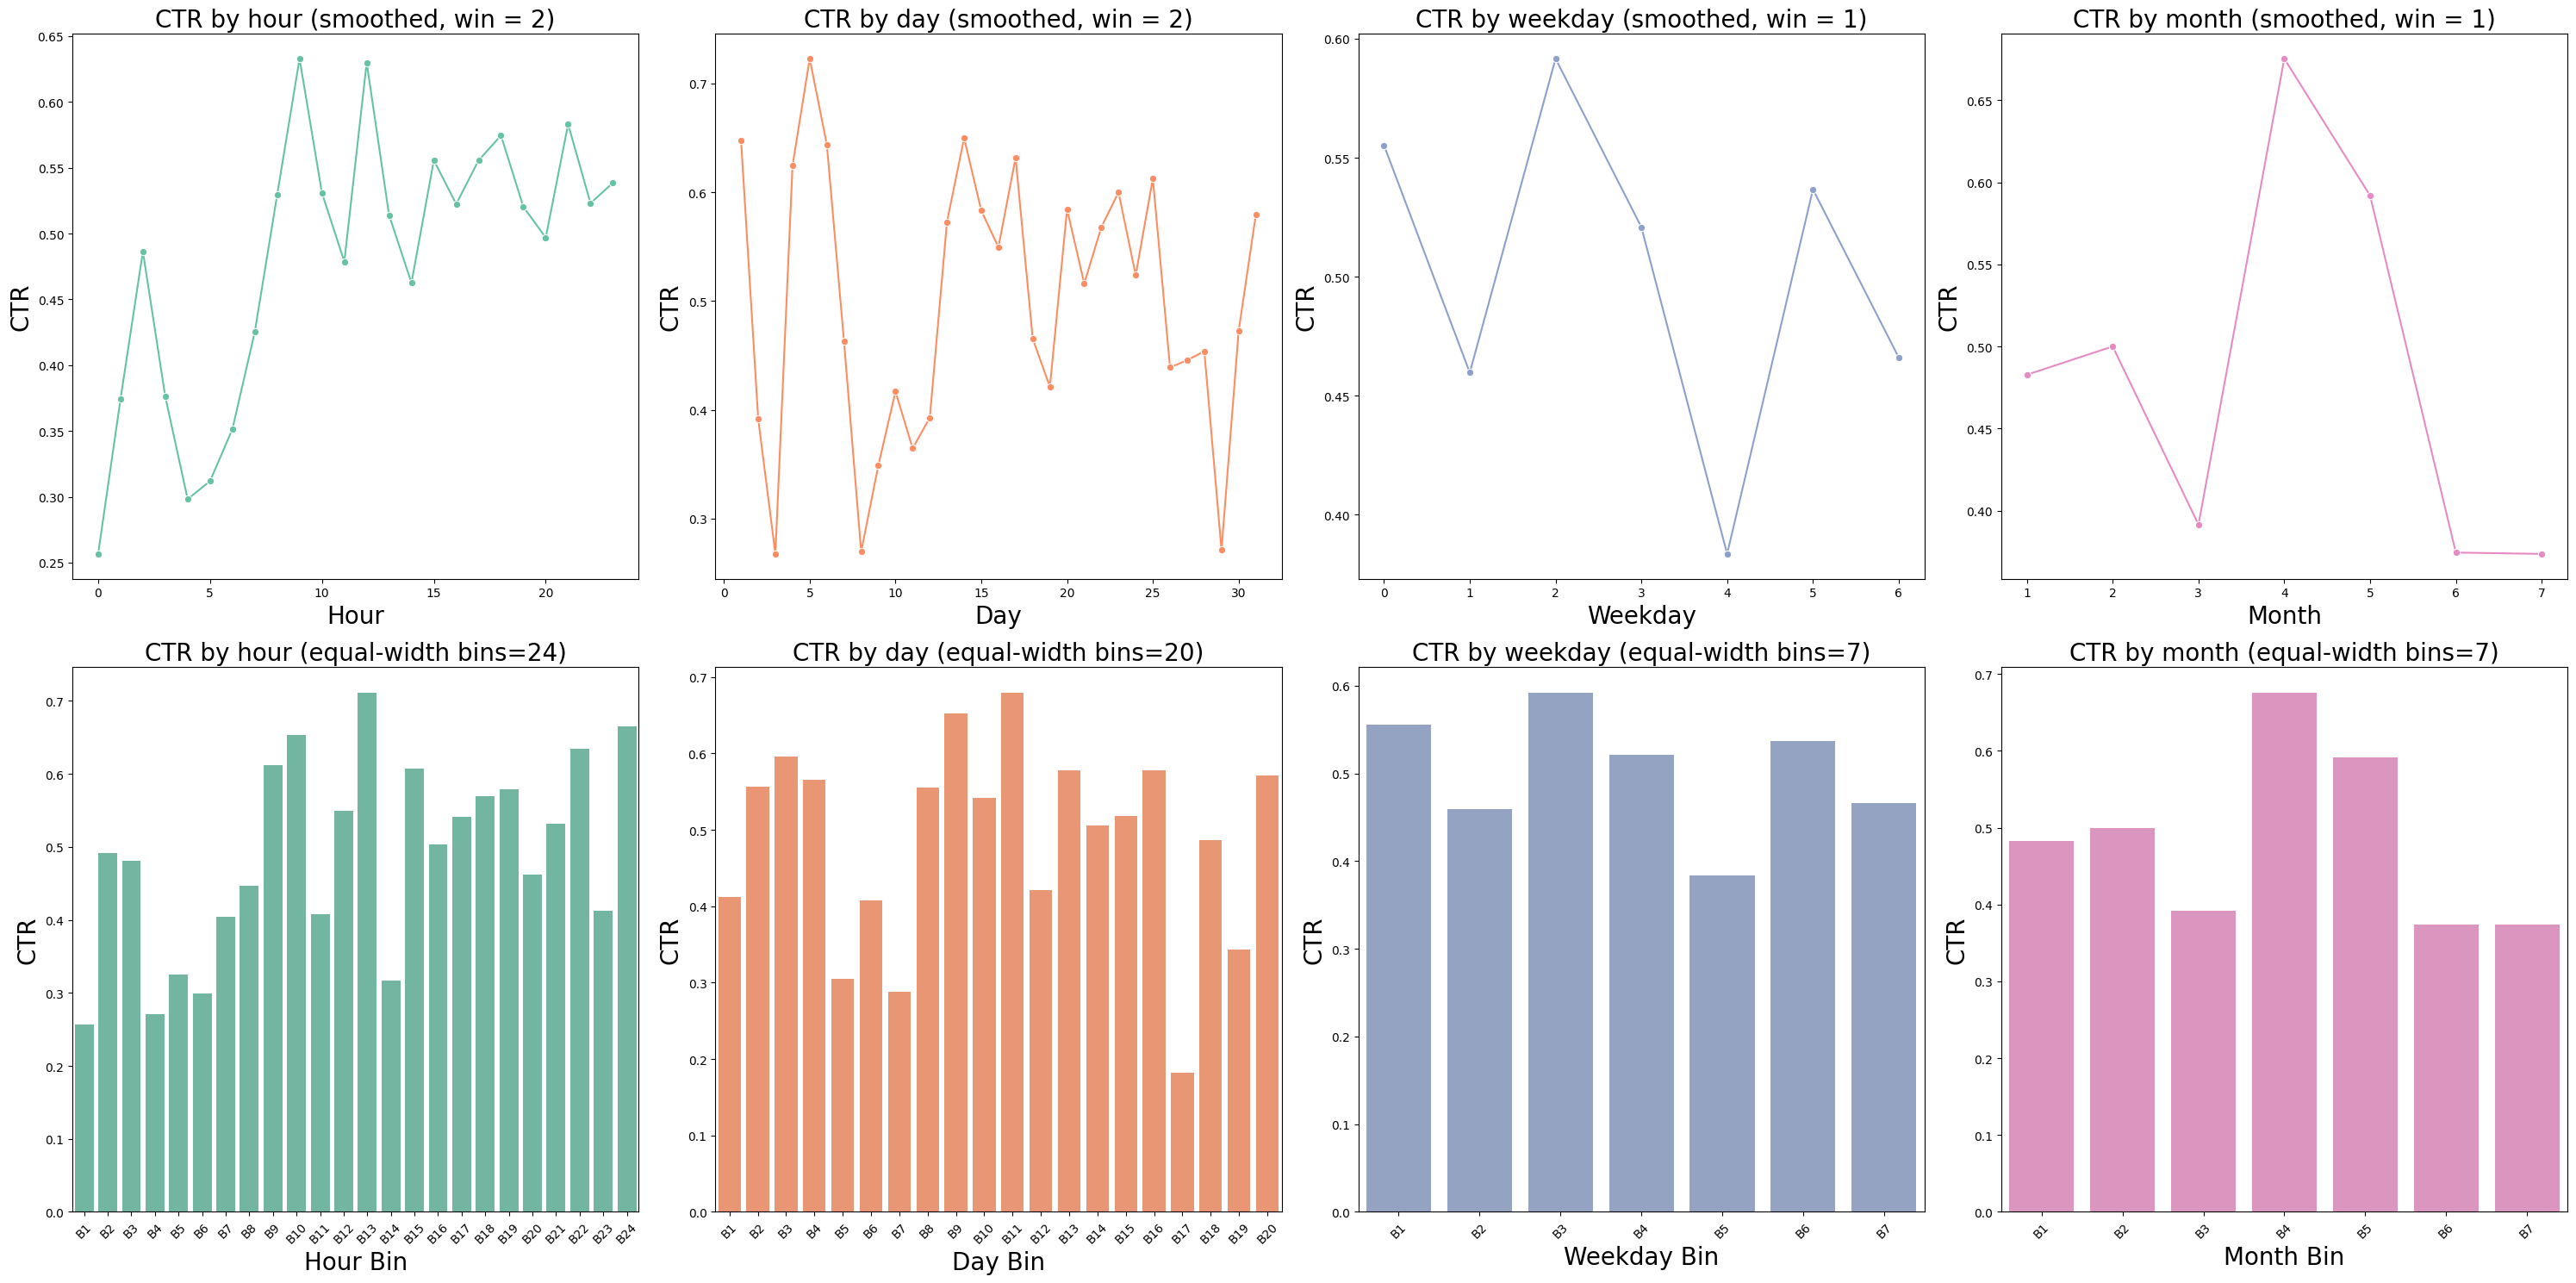

In [14]:
plot_ctr_by_numeric_columns(
    df = df,
    cols = ['hour', 'day', 'weekday', 'month'],
    n_rows = 2,
    n_cols = 4,
    n_bins = 7,
    bins_map = {'hour': 24,'day': 20, 'month': 7},
    smooth_map = {'hour': 2,'day': 2},
    figsize = (30, 15),
    rolling_window = 1,
    num_colors = sns.color_palette("Set2", 8))

In [15]:
sorted(df.month.unique())
# Since I specified 7 bins for month above, the bin B4 in the months plot
# corresponds to the 4th month in the list below... where 1 is January.

[1, 2, 3, 4, 5, 6, 7]

**Observation**   

Ad performance varies significantly across time. Click-through rates (CTR) peak during specific **hours (10AM, 12PM, and 8PM)** and **days (Wednesdays, as well as start and middle of the month)**, while ad delivery tends to concentrate **late at night**. Notably, **April (B4) sees the highest monthly CTR**, followed by a noticeable dip in **June and July**.

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

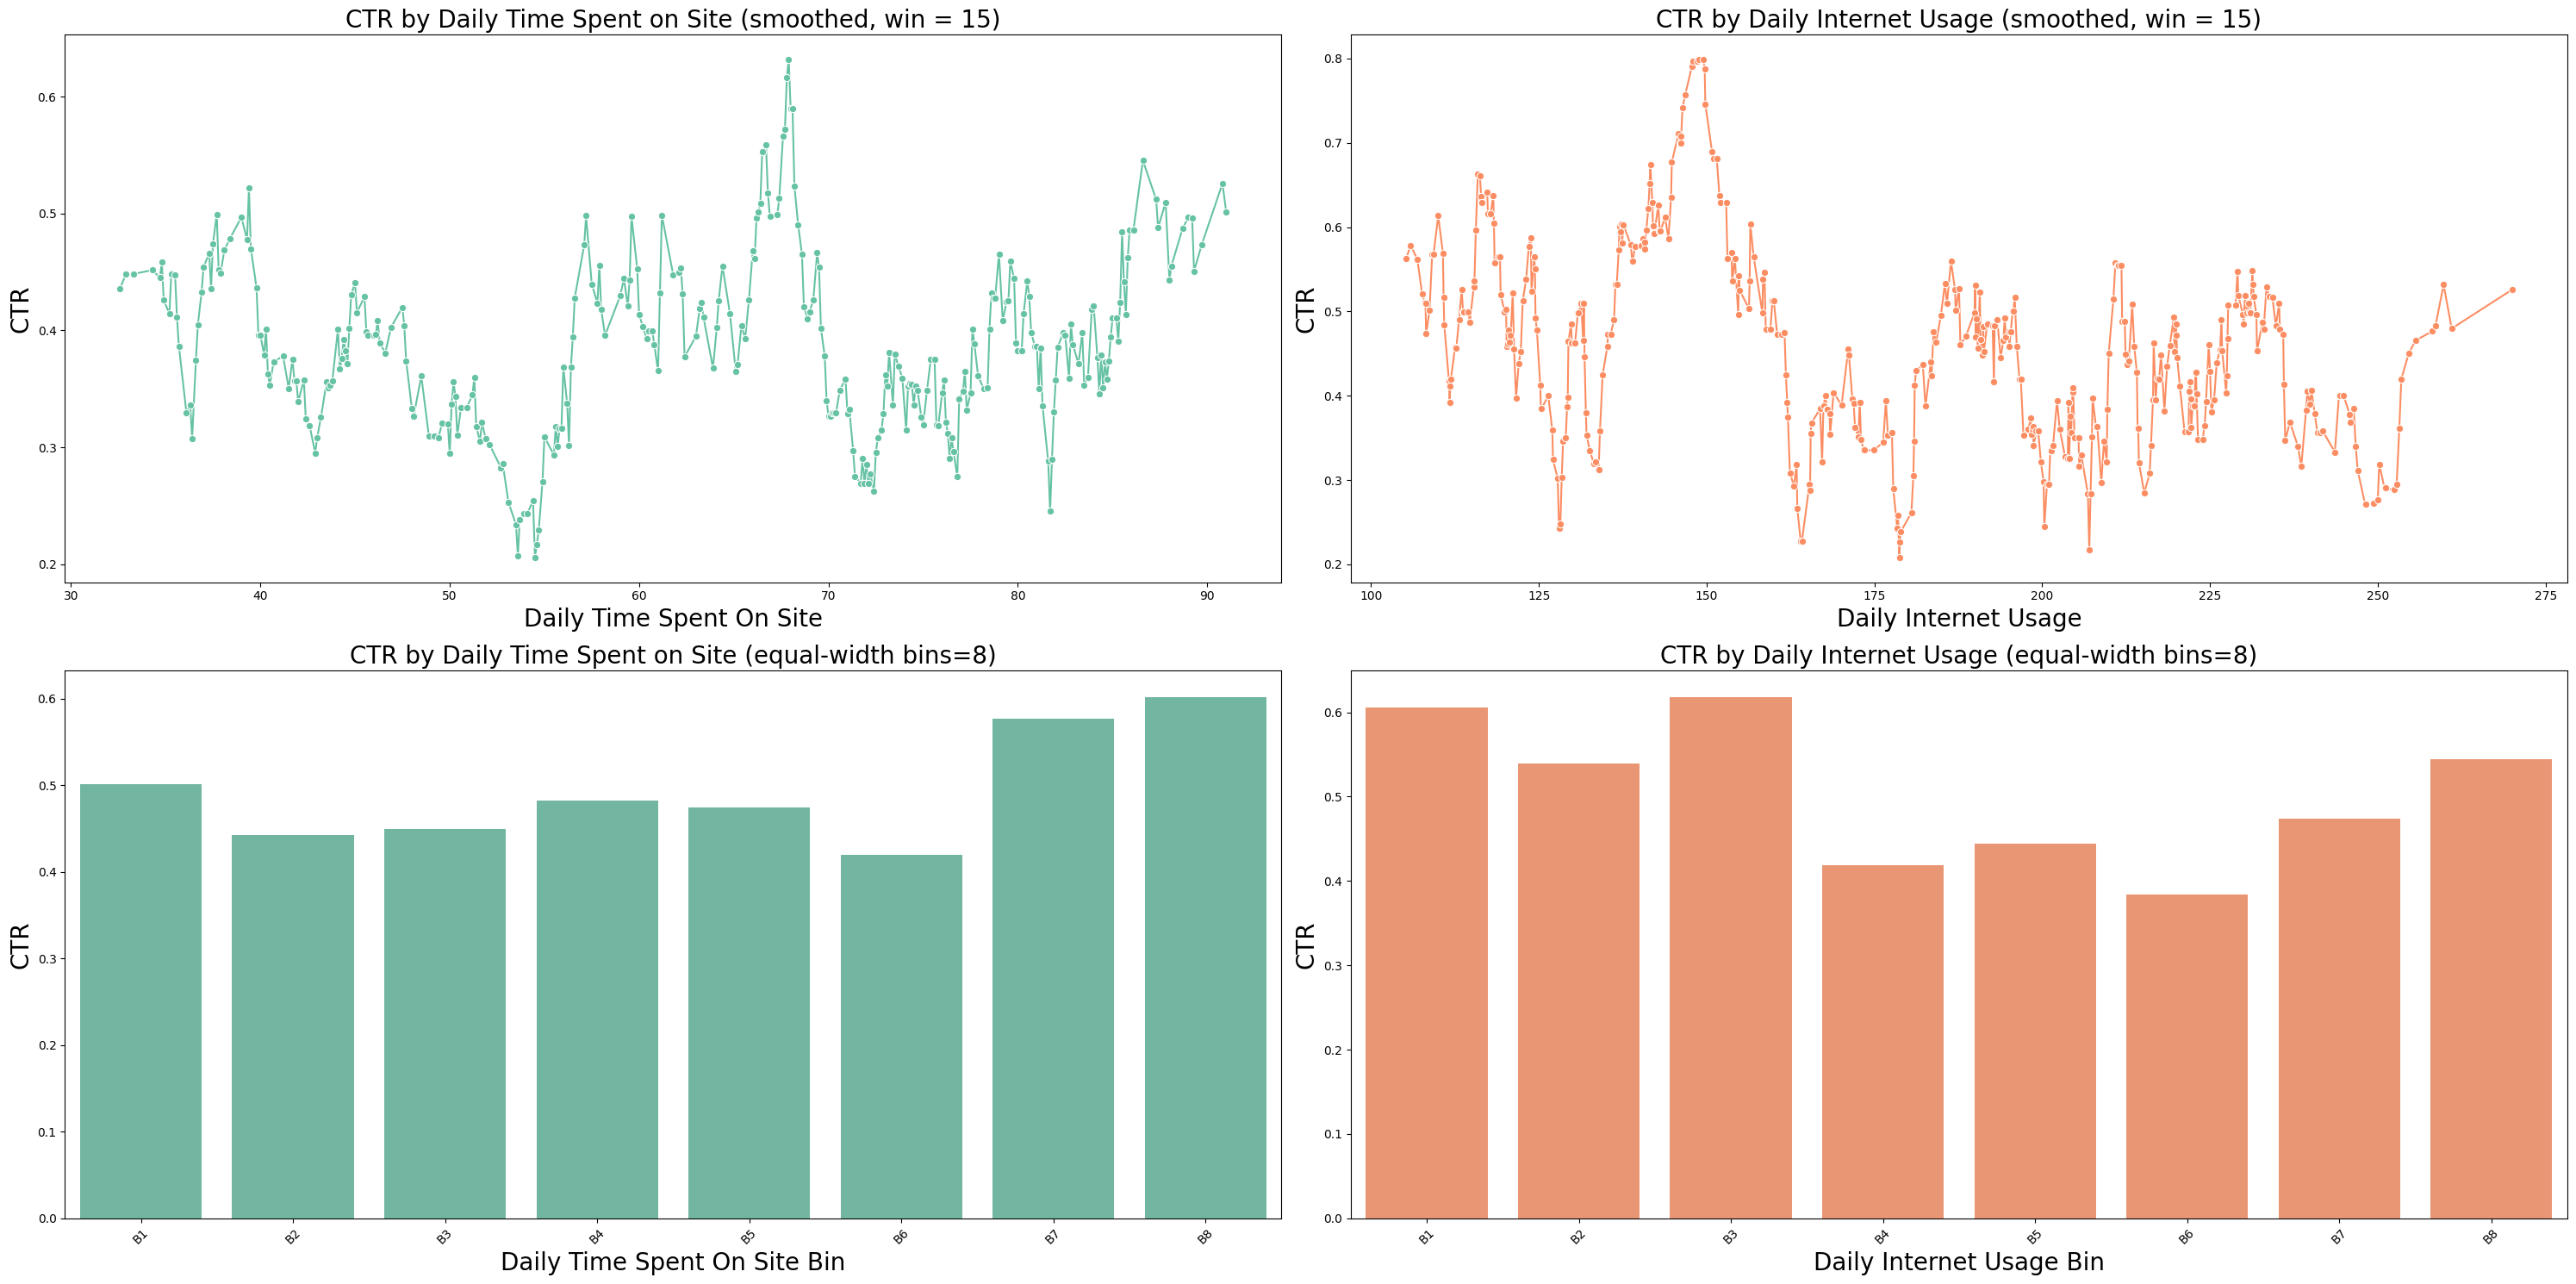

In [16]:
plot_ctr_by_numeric_columns(
    df = df,
    cols = ['Daily Time Spent on Site', 'Daily Internet Usage'],
    n_rows = 2,
    n_cols = 2,
    n_bins = 8,
    figsize = (30, 15),
    rolling_window = 15,
    num_colors = sns.color_palette("Set2", 8))

**Observation**   

CTR tends to increase with moderate user engagement, peaking with **around 70 minutes on site** and **moderate daily internet usage** but declines at extreme levels.

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

## Internet Use & Time on Site Interaction Impact Analysis

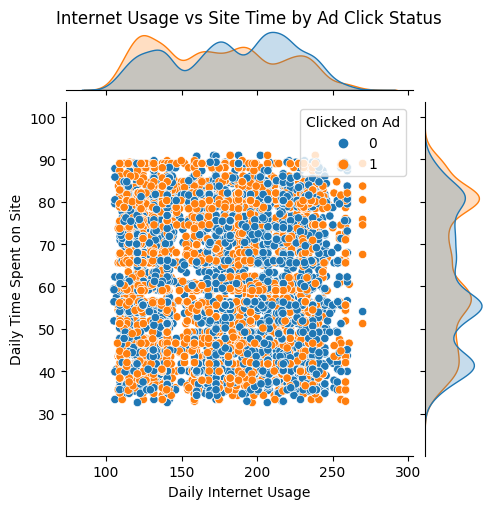

In [17]:
sns.jointplot(
    data = df,
    x = 'Daily Internet Usage',
    y = 'Daily Time Spent on Site',
    hue = 'Clicked on Ad',
    height = 5)

plt.suptitle('Internet Usage vs Site Time by Ad Click Status', y = 1.01) #, x = 0.008)
plt.show()

**Observation**   
There is no observable effect on the interaction between daily time spent on site and daily internet usage, and their impact on clicking... The values are mixed with each other, with no clear separation.

> For a more detailed breakdown of hourly, daily, and monthly trends, refer to the **Summary section**.

# Molde Training & Evaluation

In [18]:
drop_cols = ['Clicked on Ad', 'Ad Topic Line', 'City', 'Country', 'Timestamp', 'Gender']
drop_cols.extend([col for col in df.columns if 'bin' in col])


X = df.drop(columns = drop_cols, axis = 1)
y = df['Clicked on Ad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y)

# X_train, X_calib, y_train, y_calib = train_test_split(
#     X_train, y_train,
#     test_size = 0.2,
#     random_state = 42,
#     stratify = y_train)

print(f'Train Set split: {y_train.value_counts()}')
# print(f'\nCalibration Set split: {y_calib.value_counts()}')
print(f'\nTest Set split: {y_test.value_counts()}')

Train Set split: Clicked on Ad
0    4066
1    3934
Name: count, dtype: int64

Test Set split: Clicked on Ad
0    1017
1     983
Name: count, dtype: int64


## Model Selection

In [19]:
results_df = evaluate_classification_models(X_train, X_test, y_train, y_test, random_state = 32)
results_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3934, number of negative: 4066
[LightGBM] [Info] Total Bins 1450
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491750 -> initscore=-0.033003
[LightGBM] [Info] Start training from score -0.033003


,0,1,2,3,4,5,6,7,8,9,10,11,12
Model,XGBoost,LightGBM,CatBoost,HistGradientBoosting,Random Forest,Extra Trees,Gradient Boosting,Decision Tree,AdaBoost,K-Nearest Neighbors,Naive Bayes,Logistic Regression,SVM (RBF)
Accuracy,0.877,0.8745,0.873,0.8735,0.853,0.85,0.8225,0.774,0.7785,0.748,0.7405,0.7135,0.554
Precision,0.872599,0.871951,0.869301,0.873975,0.859228,0.852425,0.842048,0.762611,0.790948,0.750261,0.76484,0.711777,0.54951
Recall,0.877925,0.872838,0.872838,0.867752,0.83825,0.840285,0.786368,0.784334,0.746694,0.730417,0.681587,0.700916,0.513733
F1 Score,0.875254,0.872395,0.871066,0.870852,0.84861,0.846311,0.813256,0.77332,0.768184,0.740206,0.720818,0.706304,0.53102


**Observation**   

From the table above, the best performing model is the `XGBoost classifier`... I will now try to optimise hyper-parameters through gridsearch and see if I can squeeze out some extra accuracy.

## Hyper-parameter optimisation

In [20]:
params = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [3, 5, 7, 9, 11, 13],
    'learning_rate': [0.01, 0.06, 0.11, 0.16, 0.21, 0.26],
    'subsample': [0.7, 0.76, 0.82, 0.88, 0.94, 1.0],
    'colsample_bytree': [0.7, 0.76, 0.82, 0.88, 0.94, 1.0]}

XGBoost = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss', random_state = 32)
random_search = RandomizedSearchCV(estimator = XGBoost, param_distributions = params, n_iter = 70,
                                   cv = 3, n_jobs = -1, verbose = 0, scoring = 'f1_weighted')

random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

Best Parameters: {'subsample': 0.82, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.11, 'colsample_bytree': 0.88}
Best Cross-Validated Accuracy: 0.8663472509332221


**observation**   

Just storing results of first run, in order to avoid inconsistency, eventhough I set a random state for the model.

> {'subsample': 0.94, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.06, 'colsample_bytree': 0.82}

In [21]:
best_XGBoost = random_search.best_estimator_
y_pred = best_XGBoost.predict(X_test)

print(f'Test Set Accuracy with Best Model: {accuracy_score(y_test, y_pred)}')
print(f'Test Set Precision with Best Model: {round(precision_score(y_test, y_pred), 4)}')
print(f'Test Set Recall with Best Model: {round(recall_score(y_test, y_pred), 4)}')
print(f'Test Set F1 with Best Model: {round(f1_score(y_test, y_pred), 4)}')
print('\n\nResult from previous initial fitting...')

results_df

Test Set Accuracy with Best Model: 0.8795
Test Set Precision with Best Model: 0.8778
Test Set Recall with Best Model: 0.8769
Test Set F1 with Best Model: 0.8774


Result from previous initial fitting...


,0,1,2,3,4,5,6,7,8,9,10,11,12
Model,XGBoost,LightGBM,CatBoost,HistGradientBoosting,Random Forest,Extra Trees,Gradient Boosting,Decision Tree,AdaBoost,K-Nearest Neighbors,Naive Bayes,Logistic Regression,SVM (RBF)
Accuracy,0.877,0.8745,0.873,0.8735,0.853,0.85,0.8225,0.774,0.7785,0.748,0.7405,0.7135,0.554
Precision,0.872599,0.871951,0.869301,0.873975,0.859228,0.852425,0.842048,0.762611,0.790948,0.750261,0.76484,0.711777,0.54951
Recall,0.877925,0.872838,0.872838,0.867752,0.83825,0.840285,0.786368,0.784334,0.746694,0.730417,0.681587,0.700916,0.513733
F1 Score,0.875254,0.872395,0.871066,0.870852,0.84861,0.846311,0.813256,0.77332,0.768184,0.740206,0.720818,0.706304,0.53102


**observation**   

Well.... Anything is better than nothing at all. All metrics are much better than the base version

Up next, I will train another model using the best hyper-parameters for the sake of reproducibility, then go on to study the decision drivers behind the optimised XGBoost model. `I'm especially interested in understanding the impact of age on predicted outputs` as age has the highest correlation with clicks.

## Training & Investigating Base Model Decision Drivers

In [22]:
optimised_model = XGBClassifier(use_label_encoder = False,
                           eval_metric = 'logloss',
                           random_state = 32,
                           subsample = 0.94,
                           n_estimators = 600,
                           max_depth = 7,
                           learning_rate = 0.06,
                           colsample_bytree = 0.82)

optimised_model.fit(X_train, y_train)
y_pred = optimised_model.predict(X_test)

print(f'Test Set Accuracy with Base Model: {accuracy_score(y_test, y_pred)}')
print(f'Test Set Precision with Base Model: {round(precision_score(y_test, y_pred), 4)}')
print(f'Test Set Recall with Base Model: {round(recall_score(y_test, y_pred), 4)}')
print(f'Test Set F1 with Base Model: {round(f1_score(y_test, y_pred), 4)}')

Test Set Accuracy with Base Model: 0.887
Test Set Precision with Base Model: 0.8866
Test Set Recall with Base Model: 0.883
Test Set F1 with Base Model: 0.8848


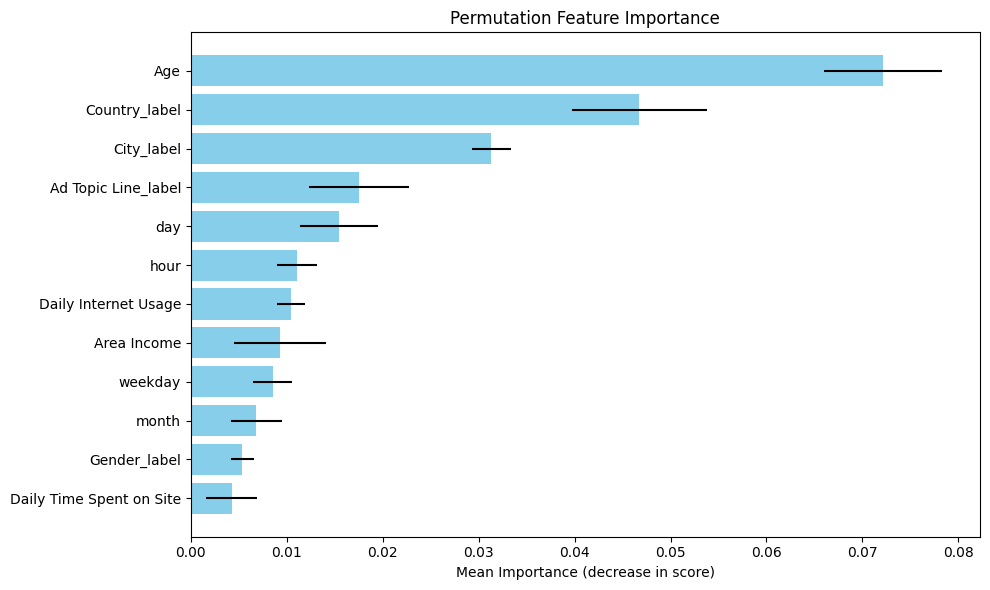

In [23]:
result = permutation_importance(optimised_model, X_test, y_test, n_repeats = 10, random_state = 42)

importances = result.importances_mean
std = result.importances_std
features = np.array(X_test.columns)
indices = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.barh(features[indices], importances[indices], xerr = std[indices], color = 'skyblue')
plt.xlabel('Mean Importance (decrease in score)')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

**observation**   

There's definitely an over reliance on age alone... That's a huge red flag. I will inspect further with a SHAP plot before engineering age; maybe binning into groups or just totally dropping it.

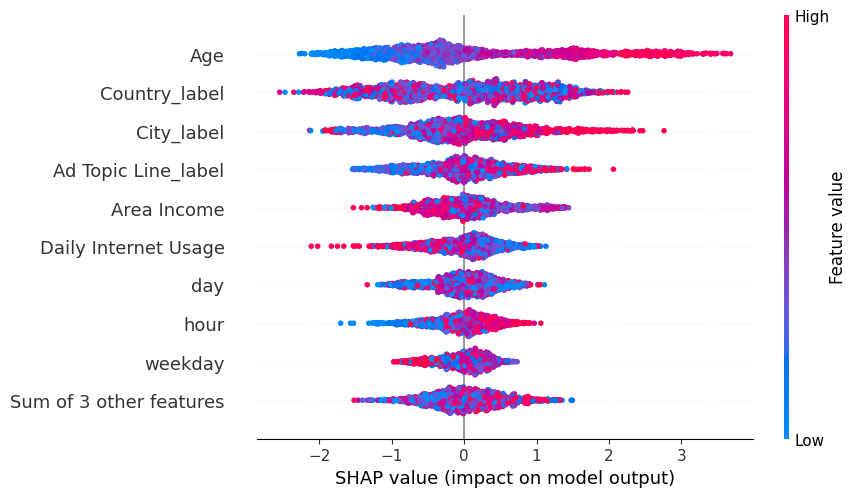

In [24]:
optimised_explainer = shap.TreeExplainer(optimised_model)
shap_values = optimised_explainer(X_test)
# shap_values.shape

shap.plots.beeswarm(shap_values)

## Investigating Age and Time Factors for Potential Feature Engineering

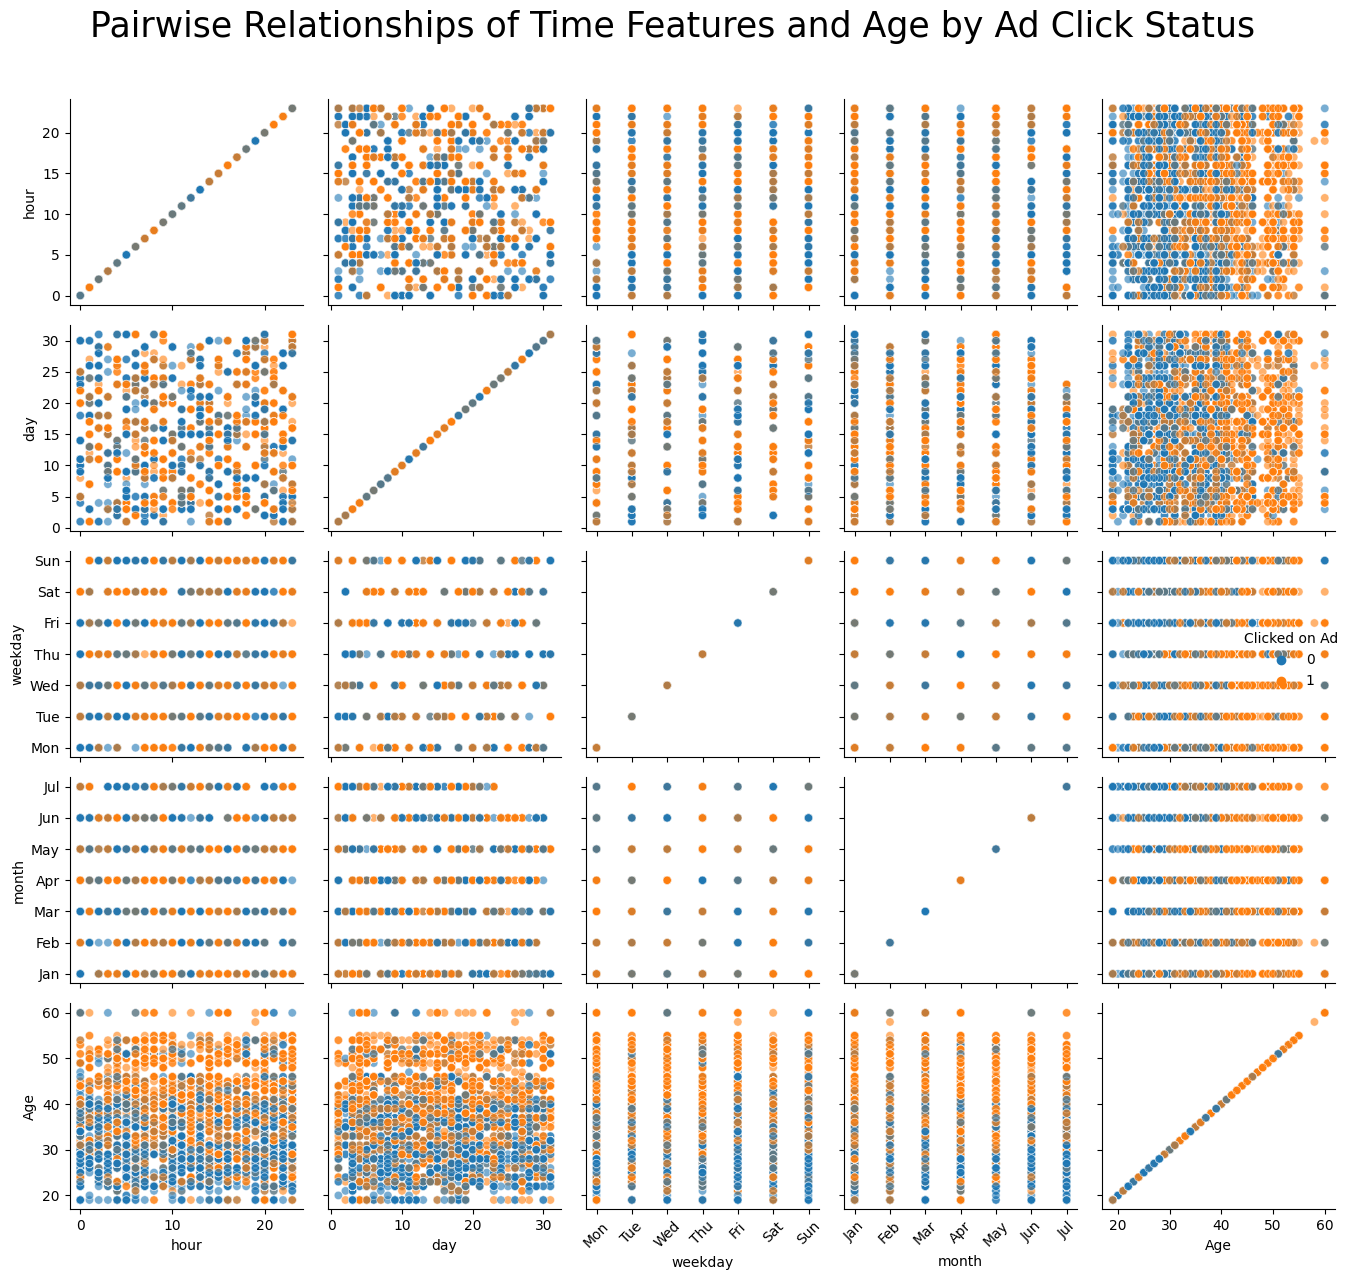

In [25]:
features = ['hour', 'day', 'weekday', 'month', 'Age']

g = sns.PairGrid(df, vars = features, hue = 'Clicked on Ad', height = 2.5)
g.map(sns.scatterplot, alpha = 0.6)

g.add_legend(title = 'Clicked on Ad', bbox_to_anchor = (1.0, 0.5))

weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul']

for ax in g.axes.flatten():
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    
    if xlabel == 'weekday':
        ax.set_xticks(range(7))
        ax.set_xticklabels(weekday_labels, rotation = 45)
    elif xlabel == 'month':
        ax.set_xticks(range(1, 8))
        ax.set_xticklabels(month_labels, rotation = 45)

    if ylabel == 'weekday':
        ax.set_yticks(range(7))
        ax.set_yticklabels(weekday_labels)
    elif ylabel == 'month':
        ax.set_yticks(range(1, 8))
        ax.set_yticklabels(month_labels)

plt.suptitle('Pairwise Relationships of Time Features and Age by Ad Click Status', y = 1.02, fontsize = 25)
plt.tight_layout()
plt.show()

**Observations**


The pairplot visualisation reveals some key patterns in the relationship between time-based features, age, and the likelihood of clicking on an ad:

- **Age** shows users over 40 appear more likely to click on ads, while younger users show less engagement.
- **Hour of the day** shows clustered behavior, indicating certain hours (late morning and evening) are more active for clicks.
- **Weekday and Month** do not exhibit strong patterns individually, but may have reasonable interaction effects with variables like month and weekday/hour for example.

---

**Feature Engineering Plan**

Based on the observed distributions and categorical nature of several features, the following engineered features will be added:

- `age_group`: age bins (`<25`, `25-35`, `45-55`, `55+`)
- `part_of_day`: Categorical bins for hour values `Morning`, `Afternoon`, `Evening`, `Night`
- `month_part`: week bins for `beginning`, `middle` and `month` end

---

**Interaction Terms**

Eventhough some potential interactions like (`Age × Hour`, `Hour × Weekday`, `Age × Part of Day`) could be helpful, I will **not explicitly model these**. Since I am training a **tree-based model (XGBoost)**, it can naturally capture such nonlinear and interaction effects through hierarchical splits.


With these new features, I will now train another XGBoost classifier, excluding the non-engineered versions of these variables. `I expect to see much better results, and less reliance on age`.

## Training and Analysing Decision Drivers of the Feature-Engineered Model

In [26]:
df['part_of_day'] = df['hour'].apply(part_of_day)

df['age_group_enc'] = pd.cut(
    df['Age'],
    bins = [0, 25, 35, 45, 55, 100],
    labels = [0, 1, 2, 3, 4]).astype(int)

df['month_part'] = pd.cut(
    df['day'],
    bins = [0, 10, 20, 31],
    labels = [0, 1, 2]).astype(int)

In [27]:
drop_cols = ['Clicked on Ad', 'Ad Topic Line', 'City', 'Country',
             'Timestamp', 'Gender', 'Age', 'hour']
drop_cols.extend([col for col in df.columns if 'bin' in col])


X = df.drop(columns = drop_cols, axis = 1)
y = df['Clicked on Ad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42,
    stratify = y)

# X_train, X_calib, y_train, y_calib = train_test_split(
#     X_train, y_train,
#     test_size = 0.2,
#     random_state = 42,
#     stratify = y_train)

print(f'Train Set split: {y_train.value_counts()}')
# print(f'\nCalibration Set split: {y_calib.value_counts()}')
print(f'\nTest Set split: {y_test.value_counts()}')

Train Set split: Clicked on Ad
0    4066
1    3934
Name: count, dtype: int64

Test Set split: Clicked on Ad
0    1017
1     983
Name: count, dtype: int64


In [28]:
fe_optimised_model = XGBClassifier(use_label_encoder = False,
                           eval_metric = 'logloss',
                           random_state = 32,
                           subsample = 0.94,
                           n_estimators = 600,
                           max_depth = 7,
                           learning_rate = 0.06,
                           colsample_bytree = 0.82)

fe_optimised_model.fit(X_train, y_train)
y_pred = fe_optimised_model.predict(X_test)
y_proba = fe_optimised_model.predict_proba(X_test)[:, 1]

print(f'Test Set Accuracy with Base Model: {accuracy_score(y_test, y_pred)}')
print(f'Test Set Precision with Base Model: {round(precision_score(y_test, y_pred), 4)}')
print(f'Test Set Recall with Base Model: {round(recall_score(y_test, y_pred), 4)}')
print(f'Test Set F1 with Base Model: {round(f1_score(y_test, y_pred), 4)}')

Test Set Accuracy with Base Model: 0.876
Test Set Precision with Base Model: 0.8708
Test Set Recall with Base Model: 0.8779
Test Set F1 with Base Model: 0.8744


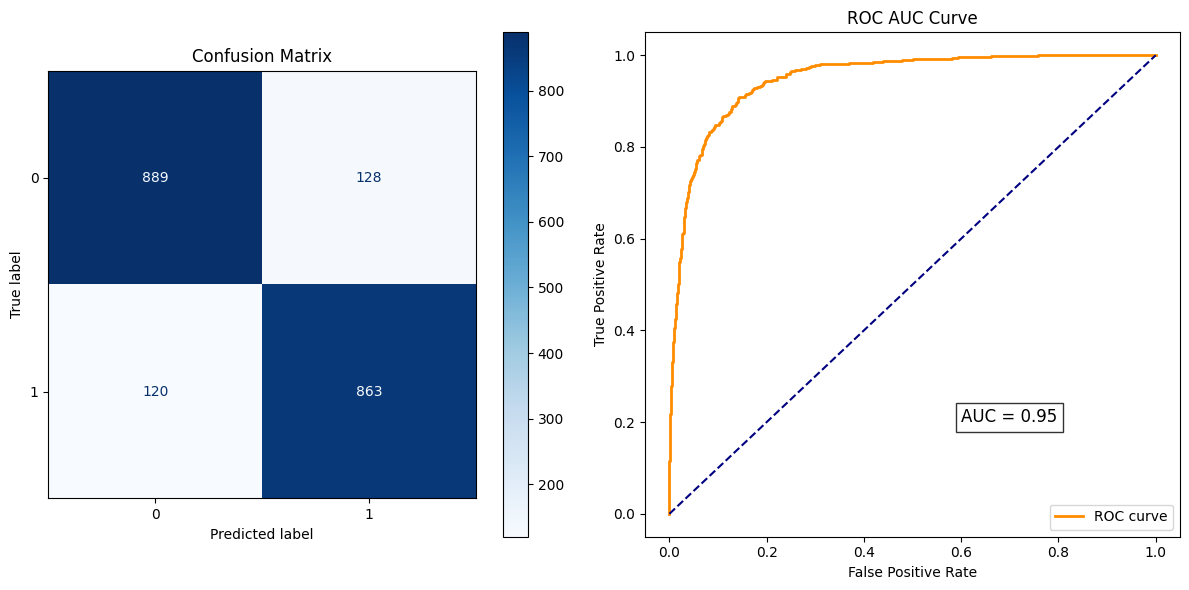

In [29]:
cm = confusion_matrix(y_test, y_pred)

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


fig = plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = fe_optimised_model.classes_)
disp.plot(cmap = 'Blues', values_format = 'd', ax = plt.gca())
plt.title("Confusion Matrix")

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve')
plt.plot([0, 1], [0, 1], color = 'navy', linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')

plt.text(0.6, 0.2, f'AUC = {roc_auc:.2f}', fontsize = 12, bbox = dict(facecolor = 'white', alpha = 0.8))

plt.legend(loc = 'lower right')
plt.tight_layout()
plt.show()

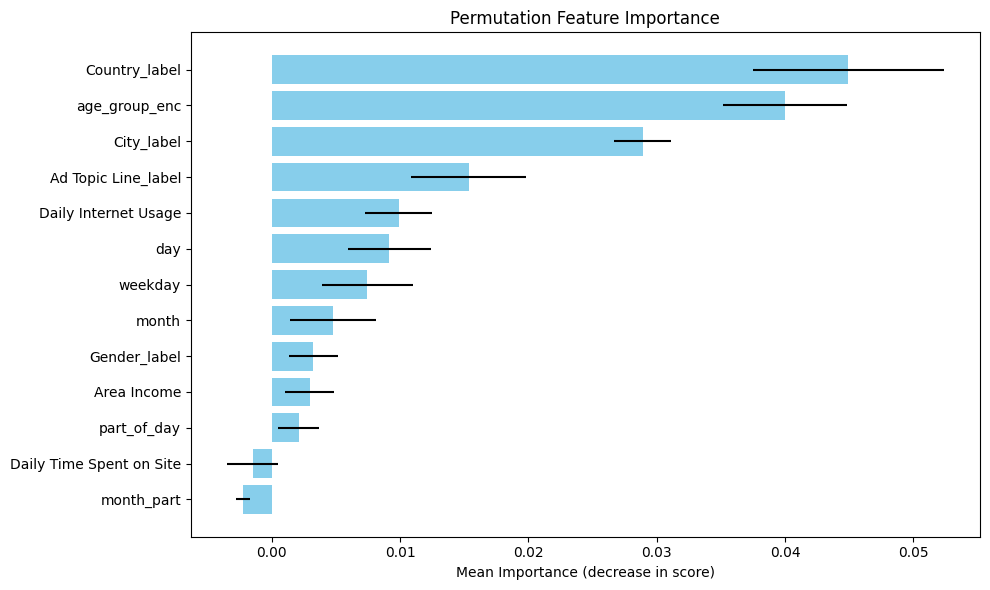

In [30]:
result = permutation_importance(fe_optimised_model, X_test, y_test, n_repeats = 10, random_state = 42)

importances = result.importances_mean
std = result.importances_std
features = np.array(X_test.columns)
indices = np.argsort(importances)

plt.figure(figsize = (10, 6))
plt.barh(features[indices], importances[indices], xerr = std[indices], color = 'skyblue')
plt.xlabel('Mean Importance (decrease in score)')
plt.title('Permutation Feature Importance')
plt.tight_layout()
plt.show()

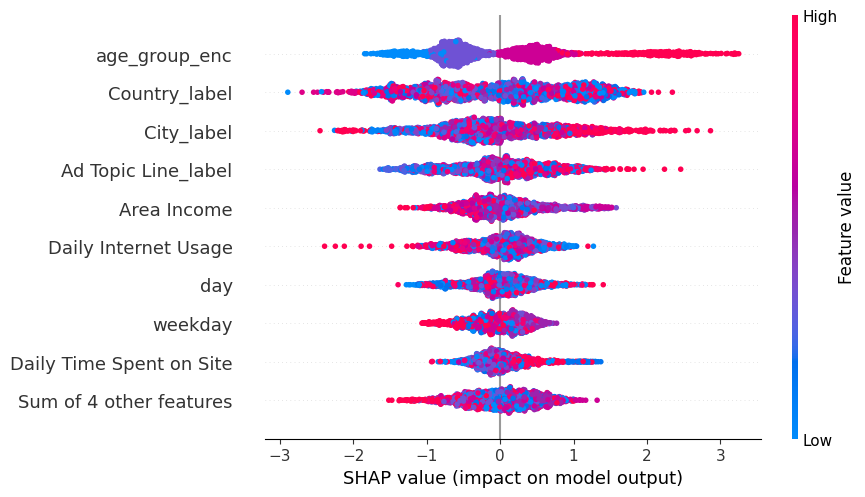

In [31]:
fe_optimised_explainer = shap.TreeExplainer(fe_optimised_model)
fe_optimised_shap_values = fe_optimised_explainer(X_test)

shap.plots.beeswarm(fe_optimised_shap_values)

## Exploring Variable Interactions and Their Influence on Model Predictions

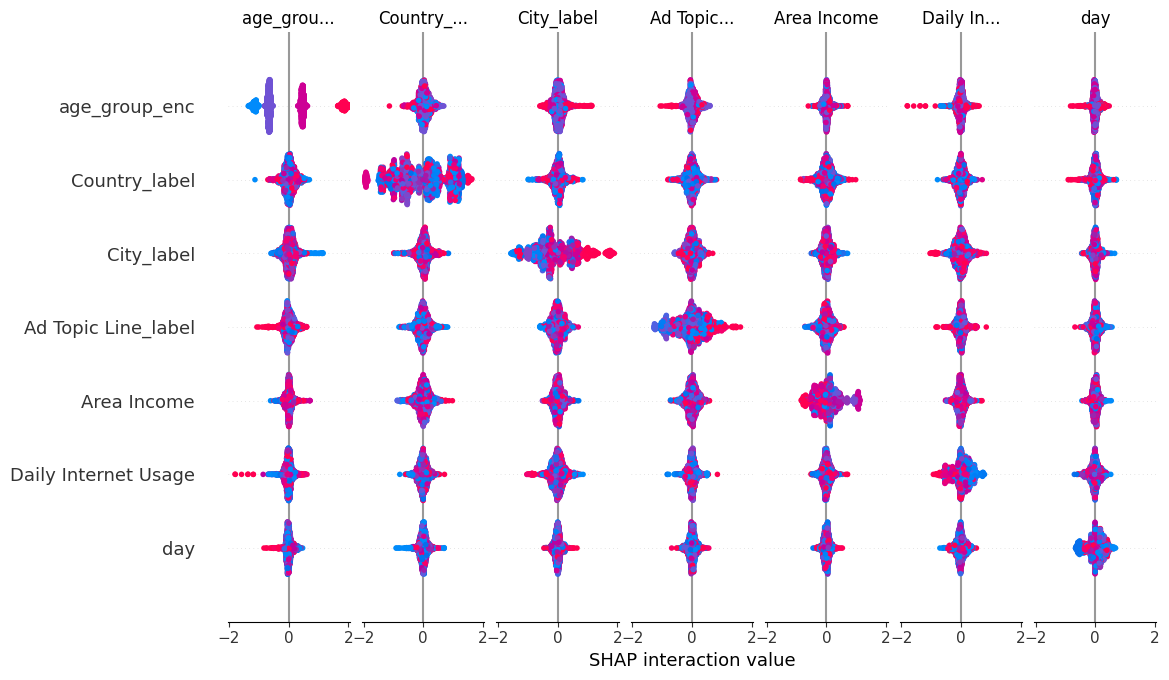

In [32]:
fe_optimised_shap_interaction_values = fe_optimised_explainer.shap_interaction_values(X_test)
shap.summary_plot(fe_optimised_shap_interaction_values, X_test)

**Observation**   

The feature engineering process was a clear success, as shown by feature dependence improvements in both the **permutation feature importance** and **SHAP value plots**.

**Why do I say so?**

Previously, the model relied heavily on **age** alone to make predictions. But now, with the engineered features, the model's decision-making has become more **balanced**, considering more factors than just age.

The updated **permutation importance** plot now shows that changes in `age` alone do **not** drastically affect model performance.


The SHAP summary plot on the other hand reinforces this understanding, showing that **Age** still matters, with older individuals more likely to click on ads, but age alone is not the major decision driver.   

The ROC/AUC curve and score are also quite impressive. The model is able to rank true positives above false positives very nicely.

***Next***

While it's possible to continue iterating to further refine my models predictions, such as training variants using only top-ranked features to remove noise, I will carry on with further steps such as **counterfactual analysis**, leveraging this well-performing model to explore *what-if* scenarios and decision boundaries.

## Analysing Segments with the Highest Misclassification Rates

In [33]:
# I have chosen to inspect performance by first of all equally binning my 
# continuous variables, then grouping my data by each category and predicting.

X_test_bins = X_test.copy()

X_test_bins['income_bin'] = pd.qcut(X_test_bins['Area Income'], q = 4, labels = ['low', 'medium', 'high', 'very_high'])
X_test_bins['usage_bin'] = pd.qcut(X_test_bins['Daily Internet Usage'], q = 4, labels = ['low', 'medium', 'high', 'very_high'])
X_test_bins['time_bin'] = pd.qcut(X_test_bins['Daily Time Spent on Site'], q = 4, labels = ['low', 'medium', 'high', 'very_high'])

In [34]:
# in this cell, I predict for each columns unique groups, then create a table
# withntheir f1 scores, rrecision, recall...

bin_features = ['income_bin', 'usage_bin', 'time_bin']
bin_features.extend(X_train.columns.values[3:])

records = []

for feature in bin_features:
    for level in X_test_bins[feature].unique():
        idx = X_test_bins[X_test_bins[feature] == level].index
        if len(idx) == 0:
            continue

        y_true = y_test.loc[idx]
        X_slice = X_test.loc[idx]
        y_pred = fe_optimised_model.predict(X_slice)

        prec, rec, f1, _ = precision_recall_fscore_support(
            y_true, y_pred,
            average = 'weighted',
            zero_division = 0)

        records.append({
            "segment": feature,
            "level": level,
            "precision": round(prec, 3),
            "recall": round(rec, 3),
            "f1": round(f1, 3),
            "n": len(idx)})


df_seg_metrics = (pd.DataFrame(records)
                  .sort_values("f1", ascending = True)
                  .reset_index(drop = True))
# df_seg_metrics.shape

In [35]:
# Here, I group by segment and level, then compute average F1
# Then I drop those with average f1 below my satisfactory threshold

level_performance = (
    df_seg_metrics
    .groupby(['segment', 'level'], as_index = False)
    .agg(avg_f1 = ('f1', 'mean'), count = ('n', 'sum'))
    .sort_values(['segment', 'avg_f1'], ascending = [True, True])
    .reset_index(drop = True))

# extracting only low performers i.e < F1 0.5
low_level_performance = level_performance[level_performance['avg_f1'] < 0.5]

In [36]:
print(low_level_performance['segment'].unique())
low_level_performance.segment.value_counts()

['Ad Topic Line_label' 'City_label' 'Country_label']


segment
City_label             41
Ad Topic Line_label    33
Country_label          13
Name: count, dtype: int64

**Observation**    

After grouping by levels within columns, predicting, and calculating key metrics, `I have finally zeroed in on the predictions the model made the most mistakes whille predicting`   

Since there are quite a number of them for each data feature, `I will only list a few in my report, and also only further investigate top 5 for each of the features`.

In [37]:
# decoding the level names... so I can understand what I'm actually
# looking at

low_level_performance['decoded_level'] = low_level_performance.apply(
    decode_value,
    axis = 1,
    label_encoders = label_encoders,
    key_column = 'segment',
    value_column = 'level')

In [38]:
low_performance_topics =  low_level_performance[low_level_performance['segment'] == 'Ad Topic Line_label']
low_performance_cities =  low_level_performance[low_level_performance['segment'] == 'City_label']
low_performance_countries =  low_level_performance[low_level_performance['segment'] == 'Country_label']

### Topic focus

In [39]:
low_performance_topics.head()

,segment,level,avg_f1,count,decoded_level
0,Ad Topic Line_label,17,0.0,1,Assimilated Multi-State Paradigm
1,Ad Topic Line_label,36,0.0,1,Business-Focused Value-Added Definition
2,Ad Topic Line_label,50,0.0,1,Configurable 24/7 Hub
3,Ad Topic Line_label,54,0.0,1,Configurable Dynamic Secured Line
4,Ad Topic Line_label,70,0.0,1,Customer-Focused Fault-Tolerant Implementation


### Cities focus

In [40]:
low_performance_cities.head()

,segment,level,avg_f1,count,decoded_level
365,City_label,1,0.0,1,Alexandrafort
366,City_label,10,0.0,1,Bakerhaven
367,City_label,43,0.0,1,Crawfordfurt
368,City_label,68,0.0,1,East Ericport
369,City_label,101,0.0,2,Evansville


### Countries focus

In [41]:
low_performance_countries.head()

,segment,level,avg_f1,count,decoded_level
718,Country_label,69,0.0,1,Greenland
719,Country_label,89,0.0,1,Italy
720,Country_label,170,0.0,1,South Georgia And The South Sandwich Islands
721,Country_label,181,0.0,1,Thailand
722,Country_label,189,0.0,1,Turks And Caicos Islands


# Counterfactual Uplift Simulation: What Could Have Turned Non-Clickers Into Clickers?

In [42]:
# analysis only on test set non-clickers
non_clickers = (y_test == 0) & (fe_optimised_model.predict(X_test) == 0)
X_non_click = X_test.loc[non_clickers].copy()

X_non_click['click_predicted_prob'] = fe_optimised_model.predict_proba(X_non_click)[:, 1]

print(f'Number of correctly predicted non-clickers: {len(X_non_click)}')

Number of correctly predicted non-clickers: 889


In [43]:
X_non_click.head(5)

,Daily Time Spent on Site,Area Income,Daily Internet Usage,day,weekday,month,Ad Topic Line_label,City_label,Gender_label,Country_label,part_of_day,age_group_enc,month_part,click_predicted_prob
8186,71.33,61601.05,212.87,3,6,1,222,115,0,97,2,2,0,0.170472
9179,52.68,73889.99,226.54,2,5,7,33,338,1,81,2,1,0,0.001196
5584,40.04,55121.65,172.81,15,0,2,481,136,1,44,1,0,1,0.116001
6847,80.51,51920.49,136.21,19,4,2,449,17,0,196,2,0,1,0.157089
1591,55.60,56180.93,165.52,7,3,4,530,318,1,81,1,2,0,0.097830


In [44]:
adjustable_features = ['part_of_day', 'Ad Topic Line_label', 'age_group_enc',
                       'Gender_label', 'weekday', 'month', 'month_part']

possible_values_dict = {
    'part_of_day': X_non_click['part_of_day'].unique(),
    'Ad Topic Line_label': X_non_click['Ad Topic Line_label'].unique(),
    'age_group_enc': X_non_click['age_group_enc'].unique(),
    'Gender_label': X_non_click['Gender_label'].unique(),
    'weekday': X_non_click['weekday'].unique(),
    'month': X_non_click['month'].unique(),
    'month_part': X_non_click['month_part'].unique()}

In [45]:
# # for individual tests
# sample = X_non_click.iloc[0][:-1]
# changes_df, original_prob, best_prob = generate_counterfactuals(sample,
#                                                    fe_optimised_model,
#                                                    adjustable_features,
#                                                    possible_values_dict)

# display(changes_df)
# print(original_prob)
# print(best_prob)

In [46]:
results = []

for idx, row in X_non_click.iterrows():
    cf_long_df, original_prob, improved_prob = generate_counterfactuals(
        row[:-1], fe_optimised_model, adjustable_features, possible_values_dict)
    
    results.append({
        'original_index': idx,
        'original_prob': original_prob,
        'improved_prob': improved_prob,
        'counterfactuals': cf_long_df})

cf_df = pd.DataFrame(results)

In [47]:
print(f'Counterfactual analysis has identified {len(cf_df[cf_df["improved_prob"] >= 0.5])} samples for which changes could increase the predicted probability to a click (>= 0.5), out of {len(X_non_click)} total samples.')

Counterfactual analysis has identified 461 samples for which changes could increase the predicted probability to a click (>= 0.5), out of 889 total samples.


In [48]:
converted_cf = cf_df[cf_df['improved_prob'] >= 0.5]

feature_adjustment_counts = Counter()
for cf_long_df in converted_cf['counterfactuals']:
    # filtering only adjusted features (adjusted_value != '-')
    adjusted_rows = cf_long_df[cf_long_df['adjusted_value'] != '-']
    
    # count each adjusted feature name
    feature_adjustment_counts.update(adjusted_rows['feature_name'])

# sort list desc
sorted_features = feature_adjustment_counts.most_common()
print('Feature adjustment counts leading to improved conversion (>0.5 predicted probability):\n')
for feature, count in sorted_features:
    print(f"{feature}: {count}")

Feature adjustment counts leading to improved conversion (>0.5 predicted probability):

age_group_enc: 298
Ad Topic Line_label: 148
weekday: 7
month: 7
Gender_label: 1


In [49]:
converted_cf = cf_df[cf_df['improved_prob'] >= 0.5]

rows = []
for cf_long_df in converted_cf['counterfactuals']:
    adjusted_rows = cf_long_df[cf_long_df['adjusted_value'] != '-']
    for _, row in adjusted_rows.iterrows():
        rows.append({
            'feature': row['feature_name'],
            'original_value': row['feature_value'],
            'adjusted_value': row['adjusted_value']})

changes_df = pd.DataFrame(rows)
summary_df = (
    changes_df
    .groupby(['feature', 'original_value', 'adjusted_value'])
    .size()
    .reset_index(name = 'count')
    .sort_values(by = 'count', ascending = False))

In [50]:
summary_df.head()

,feature,original_value,adjusted_value,count
84,age_group_enc,1.0,3.0,133
82,age_group_enc,0.0,3.0,85
85,age_group_enc,2.0,3.0,78
67,Ad Topic Line_label,437.0,557.0,12
46,Ad Topic Line_label,233.0,557.0,8


In [51]:
summary_df['original_value'] = summary_df.apply(
    decode_value,
    axis = 1,
    label_encoders = label_encoders,
    key_column = 'feature',
    value_column = 'original_value')

summary_df['adjusted_value'] = summary_df.apply(
    decode_value,
    axis = 1,
    label_encoders = label_encoders,
    key_column = 'feature',
    value_column = 'adjusted_value')


age_group_map = {
    0: 'Age 0–25', 1: 'Age 26–35',
    2: 'Age 36–45', 3: 'Age 46–55', 4: 'Age 56+'}

month_map = {
    1: 'January', 2: 'February', 3: 'March',
    4: 'April', 5: 'May', 6: 'June', 7: 'July'}

weekday_map = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday',
    3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}


summary_df.loc[summary_df['feature'] == 'age_group_enc', 'original_value'] = (
    summary_df.loc[summary_df['feature'] == 'age_group_enc', 'original_value'].astype(int).map(age_group_map))

summary_df.loc[summary_df['feature'] == 'age_group_enc', 'adjusted_value'] = (
    summary_df.loc[summary_df['feature'] == 'age_group_enc', 'adjusted_value'].astype(int).map(age_group_map))

summary_df.loc[summary_df['feature'] == 'month', 'original_value'] = (
    summary_df.loc[summary_df['feature'] == 'month', 'original_value'].astype(int).map(month_map))

summary_df.loc[summary_df['feature'] == 'month', 'adjusted_value'] = (
    summary_df.loc[summary_df['feature'] == 'month', 'adjusted_value'].astype(int).map(month_map))

summary_df.loc[summary_df['feature'] == 'weekday', 'original_value'] = (
    summary_df.loc[summary_df['feature'] == 'weekday', 'original_value'].astype(int).map(weekday_map))

summary_df.loc[summary_df['feature'] == 'weekday', 'adjusted_value'] = (
    summary_df.loc[summary_df['feature'] == 'weekday', 'adjusted_value'].astype(int).map(weekday_map))

### Counterfactual Analisis Result

In [52]:
summary_df = summary_df.reset_index(drop = True)

summary_df_age = summary_df[summary_df['feature'] == 'age_group_enc']
summary_df_topic = summary_df[summary_df['feature'] == 'Ad Topic Line_label']
summary_df_month = summary_df[summary_df['feature'] == 'month']
summary_df_weekday = summary_df[summary_df['feature'] == 'weekday']
summary_df_gender = summary_df[summary_df['feature'] == 'Gender_label']

In [53]:
summary_df_age.head()

,feature,original_value,adjusted_value,count
0,age_group_enc,Age 26–35,Age 46–55,133
1,age_group_enc,Age 0–25,Age 46–55,85
2,age_group_enc,Age 36–45,Age 46–55,78
46,age_group_enc,Age 0–25,Age 36–45,1
47,age_group_enc,Age 26–35,Age 36–45,1


In [54]:
summary_df_topic.head()

,feature,original_value,adjusted_value,count
3,Ad Topic Line_label,Sharable Reciprocal Project,Visionary Mission-Critical Application,12
4,Ad Topic Line_label,Managed Client-Server Access,Visionary Mission-Critical Application,8
5,Ad Topic Line_label,Cloned Explicit Middleware,Visionary Mission-Critical Application,6
6,Ad Topic Line_label,Digitized Content-Based Circuit,Visionary Mission-Critical Application,6
7,Ad Topic Line_label,Intuitive Exuding Service-Desk,Visionary Mission-Critical Application,5


In [55]:
summary_df_month.head()

,feature,original_value,adjusted_value,count
17,month,January,July,3
26,month,July,February,2
48,month,July,January,1
49,month,July,April,1


In [56]:
summary_df_weekday.head()

,feature,original_value,adjusted_value,count
27,weekday,Friday,Monday,2
50,weekday,Tuesday,Sunday,1
51,weekday,Friday,Tuesday,1
52,weekday,Friday,Wednesday,1
53,weekday,Sunday,Wednesday,1


In [57]:
summary_df_gender.head()

,feature,original_value,adjusted_value,count
45,Gender_label,Male,Female,1


<!-- 

---

## Key Findings

### **(EDA-Based)**

1. #### **Q**: ***How does user demographic information (age, income) relate to CTR?***   
  **A**: User demographic features have varying impact on CTR with the following specifications

  - **Age**: CTR increases steadily with age. From as low as ~0.2 from users' in their 20s, rising further between 30s and 40s, and peaking around 0.9 for users in their 50s - 60s.
  - **Income** CTR shows a non-linear relationship with area income, peaking among middle-income areas around $40K, and then gradually declining beyond that point.


2. #### **Q**: ***Do time-based behavior (e.g., daily time spent on site, internet usage, timestamp patterns) influence likelihood of clicking on ads?***  
  **A**: `Yes`, ad-clicks vary by several time-based behavioral factors:  
  - **Daily Time Spent on Site**: Higher CTRs are observed with those who spend longer time on the site, peaking around 70 minutes, with a dip around the 55-minute mark, and after its peak.
  - **Daily Internet Usage**: CTR is highest at moderate usage levels around 140–150, and declines with higher usage.  
  - **Hourly Performance**: CTR steadily increases through the morning and peaks twice `around 10AM, and 12PM`. There's another rise after 8PM.  
  - **Daily Patterns**: CTR is `highly volatile across days`. `Strong performance` is observed at the `start of the month` and again around the `23rd–26th`.   
  - **Weekday Performance**: `Wednesday` stands out with the `highest CTR`, possibly reflecting mid-week browsing intent. `Friday` has the `lowest CTR`, indicating users might be less engaged heading into the weekend.
  - **Monthly Trends**: CTR peaks in April, coinciding with the highest ad volume, then it drops `significantly` in June and July...

3. #### **Q**: ***Are there geographic differences in ad engagement (by city or country)?***   
  **A**: **`Yes`**. Cities such as `New Travistown` and `Westshire`, along with countries like `Tonga` and `Netherlands`, account for the highest CTRs. In contrast, cities like `Gracitown` and `Kingshire`, and countries such as `Singapore` and `Cameroon`, show the lowest recorded CTRs. 

4. #### **Q**: ***Do certain types of 'Ad Topic Line' perform better in terms of CTR?***     
  **A**: **`Yes`**. Ad Topic lines such as `Cloned Object-Oriented Benchmark`, `Innovative Interactive Portal`, etc., are amongst the top performers, while `Front-Line Dynamic Model` and `Inverse Local Hub` are associated with the lowest clicks.

5. #### **Q**: ***What is the relationship between internet use and time on site, and how do those correlate with CTR?***     
  **A**: Even though they individually have their impact, the interaction between internet usage and time spent on site doesn't show a strong pattern of correlation with ad click behavior.

### **(Post Model-Training)**

6. #### **Q**: ***Which user attributes (age, income, location...) are most influential in driving ad clicks, according to the predictive model?***   

  **A**: Based on final model trained, the most important features are:
  
- **Age Group**: The strongest driver of ad clicks. Older users are significantly more likely to click compared to younger ones. The influence of age is both large and consistent.
- **Location (Country & City)**: Where a user lives plays a major role. Some countries and cities show notably higher or lower engagement rates. These effects can vary sharply between regions.  
- **Ad Header (Ad Topic Line)**: The content or theme of the ad is a top factor in whether users click. Some topics resonate much more strongly with certain audiences.
- **Income Level (Area Income)**: Users from higher-income areas show a moderate increase in click likelihood. While not the top driver, income consistently influences ad engagement.
- **Internet Usage Behavior**: Daily internet habits matter. Users with moderate usage are more likely to engage than those with very low or very high usage.
- **Time on Site**: People who spend more time on the site are generally more likely to click, though this effect varies.
- **Day of the Week**: The specific day matters more than whether it’s a weekday or weekend. Some days consistently perform better than others.

7. #### **Q**: ***Which feature groups are most associated with unpredictable or inaccurate model predictions?***

**A**: The model demonstrates lower predictive accuracy across certain `topics`, `cities`, and `countries`, which may indicate inconsistent user behavior or limited training data coverage.

- **Topics with Most Unreliable Predictions**: Assimilated Multi-State Paradigm, Business-Focused Value-Added Definition, Configurable 24/7 Hub, Configurable Dynamic Secured Line, Customer-Focused Fault-Tolerant Implementation 

- **Cities with Poor Predictive Performance**: Alexandrafort, Bakerhaven, Crawfordfurt, East Ericport, Evansville

- **Countries with Weak Model Accuracy**: Greenland, Italy, South Georgia, Thailand, Turks and Caicos Islands


8. #### **Q**: **Which types of users are most responsive to changes in key factors?**

**A**: The counterfactual analysis highlights that certain user segments exhibit higher responsiveness to changes in key targeting factors, offering opportunities to refine audience segmentation and campaign focus:

- **Age Groups 0–45 Show Notable Responsiveness**:  
  Users in the `0–25`, `26–35`, and `36–45` brackets demonstrate improved predicted engagement when hypothetically associated with characteristics of older, more responsive age groups (such as `46–55`). This indicates that these younger users have latent responsiveness that can potentially be activated through targeted messaging or expanded delivery.

- **Users React Strongly to Specific Ad Topics**:  
  Exposure to certain high-performing ad topics, especially themes like **"Visionary Mission-Critical Application"** is associated with increased engagement, particularly among users initially exposed to less effective topics (e.g., `"Sharable Reciprocal Project"`, `"Managed Client-Server Access"`). This suggests that tailoring content toward impactful themes can enhance user responsiveness.

- **Timing Factors Show Subtle Influence**:  
  Some users’ predicted engagement varies with the timing of ad delivery (day of week, month), though this effect is less pronounced compared to age and topic factors.

- **Gender Has Minimal Impact on Responsiveness**:  
  Changes in gender targeting show little effect on engagement, indicating gender may not be a critical dimension for refining audience segments in this context.


9. #### **Q**: **What changes in timing or targeting can boost engagement among the least responsive users?**

**A**: Counterfactual analysis identified `461 out of 889` users for whom targeted adjustments could increase predicted click probability to `>= 0.5`. These findings suggest practical steps to boost engagement among less responsive segments:

- **Retarget Toward More Responsive Age Groups**: Many counterfactuals indicate that users in younger age brackets, such as `Age 0–25, 26–35, and 36–45`, would have been more likely to convert if they belonged to the `Age 46–55` group. While age itself cannot be changed, this suggests that `delivering the same ads to older age groups could substantially improve conversions`. For instance, 133 cases involved shifting from 26–35 to 46–55, and 85 from 0–25 to 46–55, highlighting the strong engagement of the 46–55 demographic. There are also smaller gains when targeting 36–45 instead of younger groups.

- **Refine Ad Messaging Toward High-Performing Themes**: Several underperforming ad topics, such as `"Sharable Reciprocal Project"` or `"Managed Client-Server Access"`, saw improved predicted engagement when changed to `"Visionary Mission-Critical Application"`. This theme appears to resonate broadly with disengaged users, with notable counts (12 and 8 instances respectively) supporting this shift.

- **Adjust Ad Delivery Timing (Month and Weekday)**: Although changes here affected fewer cases, shifting ad delivery from months like `January to July`, or `July to February`, showed small but measurable improvements. Similarly, adjusting delivery days from less engaging weekdays like `Friday or Tuesday` to more engaging days such as `Monday or Wednesday` was associated with better predicted outcomes. While these adjustments are less impactful overall, they could still provide incremental gains if incorporated strategically.

- **Minimal Impact from Gender-Based Targeting**: Only one case suggested benefit from switching gender targeting (Male to Female), indicating that gender may not be a primary lever for improving engagement in this dataset.


10. #### **Q**: **What hidden trends or unexpected feature combinations did the model uncover that could inform more effective marketing strategies moving forward?**

**A**: The model revealed several nuanced and non-obvious interactions between features that can significantly influence ad engagement, highlighting opportunities for more sophisticated and personalised marketing approaches:

- **Geography Modulates Age Effects**:  
  The impact of age on ad clicks varies substantially by city. For instance, younger users in some cities exhibit engagement patterns similar to older users elsewhere. This suggests that **local cultural, economic, or social factors shape how different age groups respond**, implying that a one-size-fits-all age targeting strategy may miss key regional subtleties.

- **Ad Topic Lines Show Age-Specific Appeal**:  
  Certain ad themes resonate differently across age groups, an ad topic that performs well for middle-aged users may underperform among younger or older audiences. This calls for `dynamic content personalisation` where ad creatives are tailored not just broadly by age but fine-tuned to age-topic synergies.

- **Internet Usage Intensity Interacts with Age**:  
  Time spent online influences click likelihood differently depending on a user’s age. For example, moderate internet usage might predict high engagement for one age cohort but lower engagement for another. This finding enables `targeting users based on a combined profile of age and digital behavior`, optimising ad delivery to the most receptive segments.

- **Temporal Patterns Vary by Age Group**:  
  The day of the week impacts responsiveness unevenly across age groups, with some groups showing heightened engagement on specific days. Recognising these `age-specific temporal trends` allows marketers to schedule campaigns with greater precision, maximising impact by aligning ad delivery with when target users are most receptive.

---

### Recommendations for Optimised Targeting and Engagement

- **Prioritise Age-Based Segmentation:**  
  Focus campaigns on age groups showing strong responsiveness, especially the 46–55 demographic, while tailoring messaging for younger cohorts to enhance engagement.

- **Leverage High-Impact Ad Topics:**  
  Concentrate creative efforts on proven, resonant themes (e.g., `Visionary Mission-Critical Application1) to maximise user interest and conversion.

- **Adopt Multi-Dimensional Segmentation:**  
  Integrate factors such as geography, age, and digital behavior for more precise audience targeting rather than isolated criteria.

- **Personalise Messaging and Creative Testing:**  
  Develop and test tailored content for specific age-topic combinations to boost relevance and engagement rates.

- **Refine Campaign Scheduling:**  
  Use insights on age-related temporal patterns to optimise ad delivery timing, ensuring ads reach users when they are most receptive. -->



---

## Key Findings

### **(EDA-Based)**

1. #### **Q**: ***How does user demographic information (age, income) relate to CTR?***   
  **A**: User demographic features have varying impact on CTR with the following specifications

  - **Age**: CTR increases steadily with age. From as low as ~0.2 from users' in their 20s, rising further between 30s and 40s, and peaking around 0.9 for users in their 50s - 60s.
  - **Income** CTR shows a non-linear relationship with area income, peaking among middle-income areas around $40K, and then gradually declining beyond that point.


2. #### **Q**: ***Do time-based behavior (e.g., daily time spent on site, internet usage, timestamp patterns) influence likelihood of clicking on ads?***  
  **A**: `Yes`, ad-clicks vary by several time-based behavioral factors:  
  - **Daily Time Spent on Site**: Higher CTRs are observed with those who spend longer time on the site, peaking around 70 minutes, with a dip around the 55-minute mark, and after its peak.
  - **Daily Internet Usage**: CTR is highest at moderate usage levels around 140–150, and declines with higher usage.  
  - **Hourly Performance**: CTR steadily increases through the morning and peaks twice `around 10AM, and 12PM`. There's another rise after 8PM.  
  - **Daily Patterns**: CTR is `highly volatile across days`. `Strong performance` is observed at the `start of the month` and again around the `23rd–26th`.   
  - **Weekday Performance**: `Wednesday` stands out with the `highest CTR`, possibly reflecting mid-week browsing intent. `Friday` has the `lowest CTR`, indicating users might be less engaged heading into the weekend.
  - **Monthly Trends**: CTR peaks in April, coinciding with the highest ad volume, then it drops `significantly` in June and July...

3. #### **Q**: ***Are there geographic differences in ad engagement (by city or country)?***   
  **A**: **`Yes`**. Cities such as `New Travistown` and `Westshire`, along with countries like `Tonga` and `Netherlands`, account for the highest CTRs. In contrast, cities like `Gracitown` and `Kingshire`, and countries such as `Singapore` and `Cameroon`, show the lowest recorded CTRs. 

4. #### **Q**: ***Do certain types of 'Ad Topic Line' perform better in terms of CTR?***     
  **A**: **`Yes`**. Ad Topic lines such as `Cloned Object-Oriented Benchmark`, `Innovative Interactive Portal`, etc., are amongst the top performers, while `Front-Line Dynamic Model` and `Inverse Local Hub` are associated with the lowest clicks.

5. #### **Q**: ***What is the relationship between internet use and time on site, and how do those correlate with CTR?***     
  **A**: Even though they individually have their impact, the interaction between internet usage and time spent on site doesn't show a strong pattern of correlation with ad click behavior.

### **(Post Model-Training)**

6. #### **Q**: ***Which user attributes (age, income, location...) are most influential in driving ad clicks, according to the predictive model?***   

  **A**: Based on final model trained, the most important features are:
  
- **Age Group**: The strongest driver of ad clicks. Older users are significantly more likely to click compared to younger ones. The influence of age is both large and consistent.
- **Location (Country & City)**: Where a user lives plays a major role. Some countries and cities show notably higher or lower engagement rates. These effects can vary sharply between regions.  
- **Ad Header (Ad Topic Line)**: The content or theme of the ad is a top factor in whether users click. Some topics resonate much more strongly with certain audiences.
- **Income Level (Area Income)**: Users from higher-income areas show a moderate increase in click likelihood. While not the top driver, income consistently influences ad engagement.
- **Internet Usage Behavior**: Daily internet habits matter. Users with moderate usage are more likely to engage than those with very low or very high usage.
- **Time on Site**: People who spend more time on the site are generally more likely to click, though this effect varies.
- **Day of the Week**: The specific day matters more than whether it’s a weekday or weekend. Some days consistently perform better than others.

7. #### **Q**: ***Which feature groups are most associated with unpredictable or inaccurate model predictions?***

**A**: The model demonstrates lower predictive accuracy across certain `topics`, `cities`, and `countries`, which may indicate inconsistent user behavior or limited training data coverage.

- **Topics with Most Unreliable Predictions**: Assimilated Multi-State Paradigm, Business-Focused Value-Added Definition, Configurable 24/7 Hub, Configurable Dynamic Secured Line, Customer-Focused Fault-Tolerant Implementation 

- **Cities with Poor Predictive Performance**: Alexandrafort, Bakerhaven, Crawfordfurt, East Ericport, Evansville

- **Countries with Weak Model Accuracy**: Greenland, Italy, South Georgia, Thailand, Turks and Caicos Islands


8. #### **Q**: **Which types of users are most responsive to changes in key factors?**

**A**: The counterfactual analysis highlights that certain user segments exhibit higher responsiveness to changes in key targeting factors, offering opportunities to refine audience segmentation and campaign focus:

- **Age Groups 0–45 Show Notable Responsiveness**:  
  Users in the `0–25`, `26–35`, and `36–45` brackets demonstrate improved predicted engagement when hypothetically associated with characteristics of older, more responsive age groups (such as `46–55`). This indicates that these younger users have latent responsiveness that can potentially be activated through targeted messaging or expanded delivery.

- **Users React Strongly to Specific Ad Topics**:  
  Exposure to certain high-performing ad topics, especially themes like **"Visionary Mission-Critical Application"** is associated with increased engagement, particularly among users initially exposed to less effective topics (e.g., `"Sharable Reciprocal Project"`, `"Managed Client-Server Access"`). This suggests that tailoring content toward impactful themes can enhance user responsiveness.

- **Timing Factors Show Subtle Influence**:  
  Some users’ predicted engagement varies with the timing of ad delivery (day of week, month), though this effect is less pronounced compared to age and topic factors.

- **Gender Has Minimal Impact on Responsiveness**:  
  Changes in gender targeting show little effect on engagement, indicating gender may not be a critical dimension for refining audience segments in this context.


9. #### **Q**: **What changes in timing or targeting can boost engagement among the least responsive users?**

**A**: Counterfactual analysis identified `461 out of 889` users for whom targeted adjustments could increase predicted click probability to `>= 0.5`. These findings suggest practical steps to boost engagement among less responsive segments:

- **Retarget Toward More Responsive Age Groups**: Many counterfactuals indicate that users in younger age brackets, such as `Age 0–25, 26–35, and 36–45`, would have been more likely to convert if they belonged to the `Age 46–55` group. While age itself cannot be changed, this suggests that `delivering the same ads to older age groups could substantially improve conversions`. For instance, 133 cases involved shifting from 26–35 to 46–55, and 85 from 0–25 to 46–55, highlighting the strong engagement of the 46–55 demographic. There are also smaller gains when targeting 36–45 instead of younger groups.

- **Refine Ad Messaging Toward High-Performing Themes**: Several underperforming ad topics, such as `"Sharable Reciprocal Project"` or `"Managed Client-Server Access"`, saw improved predicted engagement when changed to `"Visionary Mission-Critical Application"`. This theme appears to resonate broadly with disengaged users, with notable counts (12 and 8 instances respectively) supporting this shift.

- **Adjust Ad Delivery Timing (Month and Weekday)**: Although changes here affected fewer cases, shifting ad delivery from months like `January to July`, or `July to February`, showed small but measurable improvements. Similarly, adjusting delivery days from less engaging weekdays like `Friday or Tuesday` to more engaging days such as `Monday or Wednesday` was associated with better predicted outcomes. While these adjustments are less impactful overall, they could still provide incremental gains if incorporated strategically.

- **Minimal Impact from Gender-Based Targeting**: Only one case suggested benefit from switching gender targeting (Male to Female), indicating that gender may not be a primary lever for improving engagement in this dataset.


10. #### **Q**: **What hidden trends or unexpected feature combinations did the model uncover that could inform more effective marketing strategies moving forward?**

**A**: The model revealed several nuanced and non-obvious interactions between features that can significantly influence ad engagement, highlighting opportunities for more sophisticated and personalised marketing approaches:

- **Geography Modulates Age Effects**:  
  The impact of age on ad clicks varies substantially by city. For instance, younger users in some cities exhibit engagement patterns similar to older users elsewhere. This suggests that **local cultural, economic, or social factors shape how different age groups respond**, implying that a one-size-fits-all age targeting strategy may miss key regional subtleties.

- **Ad Topic Lines Show Age-Specific Appeal**:  
  Certain ad themes resonate differently across age groups, an ad topic that performs well for middle-aged users may underperform among younger or older audiences. This calls for `dynamic content personalisation` where ad creatives are tailored not just broadly by age but fine-tuned to age-topic synergies.

- **Internet Usage Intensity Interacts with Age**:  
  Time spent online influences click likelihood differently depending on a user’s age. For example, moderate internet usage might predict high engagement for one age cohort but lower engagement for another. This finding enables `targeting users based on a combined profile of age and digital behavior`, optimising ad delivery to the most receptive segments.

- **Temporal Patterns Vary by Age Group**:  
  The day of the week impacts responsiveness unevenly across age groups, with some groups showing heightened engagement on specific days. Recognising these `age-specific temporal trends` allows marketers to schedule campaigns with greater precision, maximising impact by aligning ad delivery with when target users are most receptive.

---

### Recommendations for Optimised Targeting and Engagement

- **Prioritise Age-Based Segmentation:**  
  Focus campaigns on age groups showing strong responsiveness, especially the 46–55 demographic, while tailoring messaging for younger cohorts to enhance engagement.

- **Leverage High-Impact Ad Topics:**  
  Concentrate creative efforts on proven, resonant themes (e.g., `Visionary Mission-Critical Application1) to maximise user interest and conversion.

- **Adopt Multi-Dimensional Segmentation:**  
  Integrate factors such as geography, age, and digital behavior for more precise audience targeting rather than isolated criteria.

- **Personalise Messaging and Creative Testing:**  
  Develop and test tailored content for specific age-topic combinations to boost relevance and engagement rates.

- **Refine Campaign Scheduling:**  
  Use insights on age-related temporal patterns to optimise ad delivery timing, ensuring ads reach users when they are most receptive.